# Figures in [Cardinale and Rose (2023)](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2022GL100834)
---

## Overview

1. [Import data from the CESM-LE and MERRA-2, and compute daily anomalies](#1.-Import-data-and-compute-anomalies)
2. [Climatological polar energy fluxes and surface fluxes: Figures 1 and S1](#2.-Climatologies)
3. [The surface heating efficiency of tropospheric energy flux events: Figures 2, S3, and S4](#3.-The-surface-heating-efficiency-of-$F_{\mathrm{trop}}$-events)
4. [Surface heating efficiency changes and implications: Figures 3, 4, and S2](#4.-Change-in-the-winter-mean-$E_{\mathrm{trop}}$-and-surface-warming-implications)


## 1. Import data and compute anomalies
---

**Abbreviations:**
- Cp = Specific heat of dry air at constant pressure
- C = circumference of the latitude defining the polar cap boundary
- A = area of the polar cap
- hm or $h_{\mathrm{m}}$ = Moist enthalpy (sensible and latent energy)
- NSF = Net surface flux
- CRE = Surface cloud radiative effect
- $F_{\mathrm{wall}}$ = total vertically integrated energy flux convergence
- $F_{\mathrm{trop}}$ = tropospheric energy flux convergence (1000–300 hPa)
- NTES = Net tropospheric energy source
- E_trop or $E_{\mathrm{trop}}$ = metric for the Arctic surface heating efficiency of $F_{\mathrm{trop}}$ events
- H = Historical (1990$-$2005)
- F = Future (2071$-$2080)
---
**Example arrays:**
- `SH_H`: Sensible heat flux in ***historical simulations*** (20C; not vertically integrated)
- `SH_F`: Sensible heat flux in ***future simulations*** (RCP8.5; not vertically integrated)
- `SH_anomH`: Sensible heat flux anomalies in historical simulations (linearly detrended; not vertically integrated)


<div class="alert alert-info">

<strong>Note:</strong> Most terms are averaged over the polar cap (70$-$90$^{\circ}$N), except for energy fluxes, which are calculated at 70$^{\circ}$N
    
</div>

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import scipy.integrate as integ
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import scipy.stats as sp
from scipy import signal
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import metpy
from metpy.plots import SkewT

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

### Import user functions

In [2]:
import comp.functions as comp
from comp.functions import C,A,ufunc2,sid,Cp,Lv,g,Rd,h

### Load datasets (including MERRA-2)

Datasets and arrays:
- `flux`: dataset of energy fluxes at 70$^{\circ}$N (zonally averaged on pressure levels)
    - `SH`: Sensible heat flux
    - `LH`: Latent heat fluxes
    - `GP`: Geopotential energy flux
    - `MSE`: Moist static energy flux
- `MENT`: dataset of moist enthalpy components
    - `dhmdt`: Polar cap-averaged moist enthalpy tendency (pressure levels)
    - `sensible`: Polar cap-averaged sensible energy (pressure levels)
- `SFC`: dataset of surface fluxes, pressure, temperature, and sea ice concentration
    - `NLR`: Net longwave radiaiton flux 
    - `NLRC`: Clear-sky net longwave radiation flux 
    - `SHLH`: Sensible and latent turbulent heat fluxes
    - `ASR`: Absorbed shortwave radiation
    - `NSF`: Net surface flux (SHLH+NLR; winter)
    - `T2M`: temperature at 2-m
    - `PS`: surface pressure
    - `SIC`: sea ice concentration 
- `LTS`: Lower-tropsopheric (2m-850 hPa) stability
- `NTES`: Net tropospheric energy source ($F_{\mathrm{trop}}$ minus the $h_{\mathrm{m}}$ tendency)

In [3]:
data_loc = 'cesm_lens_data/'
data_loc2 = 'merra2_data/'

In [4]:
flux_H = xr.open_dataset(data_loc + 'CESM_MSE_flux_1990_2005')
SH_H = flux_H.SH_flux
LH_H = flux_H.LH_flux
GP_H = flux_H.GP_flux
MSE_H = SH_H+LH_H+GP_H

MENT_H = xr.open_dataset(data_loc + 'CESM_MENT_1990_2005')
dhmdt_H = MENT_H.dhmdt
sensible_H = MENT_H.sensible

SFC_H = xr.open_dataset(data_loc + 'CESM_SFC_1990_2005')
NLR_H = SFC_H.NLR
NLRC_H = SFC_H.NLRC
SHLH_H = SFC_H.SHLH
ASR_H = SFC_H.ASR
NSF_H = NLR_H+SHLH_H
T2M_H = SFC_H.T2M
PS_H = SFC_H.PS
SIC_H = SFC_H.SIC

flux_F = xr.open_dataset(data_loc + 'CESM_MSE_flux_2071_2080')
SH_F = flux_F.SH_flux
LH_F = flux_F.LH_flux
GP_F = flux_F.GP_flux
MSE_F = SH_F+LH_F+GP_F

MENT_F = xr.open_dataset(data_loc + 'CESM_MENT_2071_2080')
dhmdt_F = MENT_F.dhmdt
sensible_F = MENT_F.sensible

SFC_F = xr.open_dataset(data_loc + 'CESM_SFC_2071_2080')
NLR_F = SFC_F.NLR
NLRC_F = SFC_F.NLRC
SHLH_F = SFC_F.SHLH
ASR_F = SFC_F.ASR
NSF_F = NLR_F+SHLH_F
T2M_F = SFC_F.T2M
PS_F = SFC_F.PS
SIC_F = SFC_F.SIC

In [5]:
NTES_H = comp.integrate_trop((MSE_H*C/A) - (dhmdt_H/sid))

LTS_H = (-((T2M_H)*(1**.286))+
              ((sensible_H/Cp).sel(plev=85000)*((PS_H/85000)**.286)))

NTES_F = comp.integrate_trop((MSE_F*C/A) - (dhmdt_F/sid))

LTS_F = (-((T2M_F)*(1**.286))+
              ((sensible_F/Cp).sel(plev=85000)*((PS_F/85000)**.286)))

For comparison, load MERRA-2 datasets averaged between 1990 and 2005:
- `Mclim_9005` : climatological poleward MSE and surface fluxes
- `Mflux_comp_9005`: composite poleward MSE fluxes during $F_{\mathrm{trop}}$ events
- `Msfc_comp_9005`: composite surface fluxes during $F_{\mathrm{trop}}$ events

In [6]:
Mclim_9005 = xr.open_dataset(data_loc2 + 'merra2_clim_9005.nc')
Mflux_comp_9005 = xr.open_dataset(data_loc2 + 'merra2_eflux_comp_9005.nc')
#change pressure units of MERRA-2 from hPa to Pa to match CESM-LE
Mflux_comp_9005['lev'] = Mflux_comp_9005.lev*100
Msfc_comp_9005 = xr.open_dataset(data_loc2 + 'merra2_sfc_comp_9005.nc')

<div class="alert alert-info">

<strong>Note:</strong> See [CESM_LE_data_download.ipynb](https://github.com/cjcardinale/Cardinale-Rose-2022-GRL/blob/main/CESM_LE_data_download.ipynb) for data download instructions for the CESM large ensemble (CESM-LE). Instructions to download MERRA-2 data can be found in the [repository](https://github.com/cjcardinale/Cardinale-Rose-Efficiency) for [Cardinale and Rose (2022)](https://journals.ametsoc.org/view/journals/clim/35/18/JCLI-D-21-0852.1.xml): https://github.com/cjcardinale/Cardinale-et-al-2021-JCLI.
    
</div>

### Compute anomalies and linearly detrended anomalies during winter

winter (Nov$-$March) and "extended" winter (Oct$-$April) calendars

In [7]:
winter_F = MSE_F.time.where(np.logical_or(MSE_F.time.dt.month>10
                                         ,MSE_F.time.dt.month<4)).sel(time=slice('2071-01-02','2080-12-31')).dropna('time')
winter_H = NLR_H.time.where(np.logical_or(NLR_H.time.dt.month>10
                                         ,NLR_H.time.dt.month<4)).sel(time=slice('1990-01-02','2005-12-31')).dropna('time')
winter_extF = NLR_F.time.where(np.logical_or(NLR_F.time.dt.month>9
                                         ,NLR_F.time.dt.month<5)).dropna('time')
winter_extH = NLR_H.time.where(np.logical_or(NLR_H.time.dt.month>9
                                         ,NLR_H.time.dt.month<5)).dropna('time')

In [8]:
MSE_anomF = comp.detrend(comp.anom_daily_filt(MSE_F,period=winter_extF))
SH_anomF = comp.detrend(comp.anom_daily_filt(SH_F,period=winter_extF))
LH_anomF = comp.detrend(comp.anom_daily_filt(LH_F,period=winter_extF))
GP_anomF = comp.detrend(comp.anom_daily_filt(GP_F,period=winter_extF))
dhmdt_anomF = comp.detrend(comp.anom_daily_filt(dhmdt_F,period=winter_extF))
sensible_anomF = comp.detrend(comp.anom_daily_filt(sensible_F,period=winter_extF))

MSE_anomH = comp.detrend(comp.anom_daily_filt(MSE_H,period=winter_extH))
SH_anomH = comp.detrend(comp.anom_daily_filt(SH_H,period=winter_extH))
LH_anomH = comp.detrend(comp.anom_daily_filt(LH_H,period=winter_extH))
GP_anomH = comp.detrend(comp.anom_daily_filt(GP_H,period=winter_extH))
dhmdt_anomH = comp.detrend(comp.anom_daily_filt(dhmdt_H,period=winter_extH))
sensible_anomH = comp.detrend(comp.anom_daily_filt(sensible_H,period=winter_extH))

NLR_anomF = comp.detrend(comp.anom_daily_filt(NLR_F).sel(time=winter_extF))
NLRC_anomF = comp.detrend(comp.anom_daily_filt(NLRC_F).sel(time=winter_extF))
SHLH_anomF = comp.detrend(comp.anom_daily_filt(SHLH_F).sel(time=winter_extF))

NLR_anomH = comp.detrend(comp.anom_daily_filt(NLR_H).sel(time=winter_extH))
NLRC_anomH = comp.detrend(comp.anom_daily_filt(NLRC_H).sel(time=winter_extH))
SHLH_anomH = comp.detrend(comp.anom_daily_filt(SHLH_H).sel(time=winter_extH))

no nans found
no nans found
no nans found
no nans found
nans found, array filled using ffill and bfill
nans found, array filled using ffill and bfill
no nans found
no nans found
no nans found
no nans found
nans found, array filled using ffill and bfill
nans found, array filled using ffill and bfill
no nans found
no nans found
no nans found
nans found, array filled using ffill and bfill
nans found, array filled using ffill and bfill
nans found, array filled using ffill and bfill


<div class="alert alert-info">
    
<strong>Note:</strong> Detrending arrays requires no <code>nan</code> values—when found, the arrays are filled with either the previous or following value.
</div>

In [9]:
LTS_anomH = (comp.anom_daily_filt(LTS_H,period=winter_extH))
LTS_anomF = (comp.anom_daily_filt(LTS_F,period=winter_extF))

NTES_anomF = comp.integrate_trop((MSE_anomF*C/A) - (dhmdt_anomF/sid))
NTES_anomH = comp.integrate_trop((MSE_anomH*C/A) - (dhmdt_anomH/sid))

NSF_anomH = NLR_anomH + SHLH_anomH
NSF_anomF = NLR_anomF + SHLH_anomF

CRE_anomH = NLR_anomH-NLRC_anomH
CRE_anomF = NLR_anomF-NLRC_anomF

T2M_anomH = comp.anom_daily_filt(T2M_H).sel(time=winter_extH)
T2M_anomF = comp.anom_daily_filt(T2M_F).sel(time=winter_extF)

SIC_anomH = comp.anom_daily_filt(SIC_H).sel(time=winter_extH)
SIC_anomF = comp.anom_daily_filt(SIC_F).sel(time=winter_extF)

<div class="alert alert-info">
    
<strong>Note:</strong> Only the winter season is considered: absorbed shortwave radiation is negligable and the NSF is comprised of NLR and SHLH. NSF anomalies are positive <em>downward</em>.
</div>

## 2. Climatologies
---

This section includes code for reproducing Figures 1 and S1.
- Figure 1: climatological Arctic-averaged temperature, energy fluxes, and changes in energy fluxes from historical "20C" runs (1990-2005) and future "RCP8.5" runs (2071-2080) during winter
- Figure S1: daily mean annual cycle of Arctic-averaged surface fluxes 


### Figure 1

''

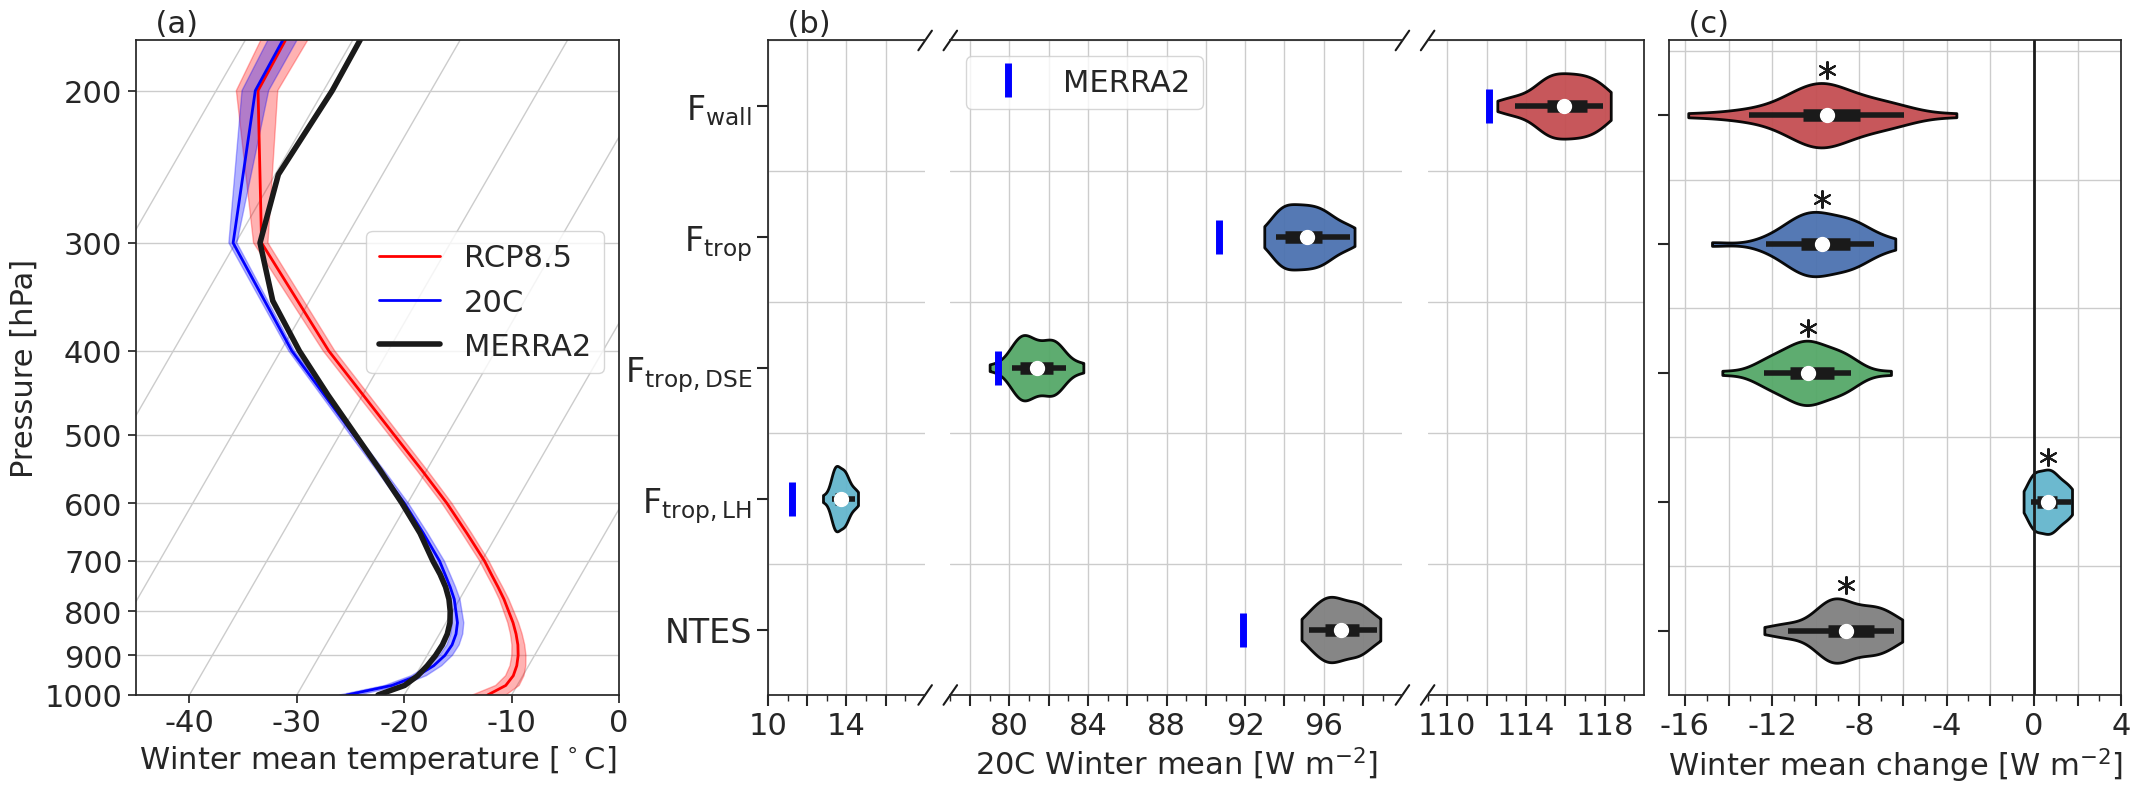

In [10]:
fig = plt.figure( figsize=(26,8.5))
gs = plt.GridSpec(1,6,
                       width_ratios=[1.2,3.5/23,8/23,1,11/23,1],
                       height_ratios=[1],
                       )


ax = fig.add_subplot(gs[2])
ax2 = fig.add_subplot(gs[3])
ax3 = fig.add_subplot(gs[4])
ax4 = fig.add_subplot(gs[5])

data= [comp.integrate_trop((LH_H)*C/A).sel(time=winter_H).mean('time')]

data2= [NTES_H.sel(time=winter_H).mean('time'),
            comp.integrate_trop((SH_H+GP_H)*C/A).sel(time=winter_H).mean('time'),
            comp.integrate_trop((MSE_H)*C/A).sel(time=winter_H).mean('time')]

data3= [comp.integrate((MSE_H)*C/A).sel(time=winter_H).mean('time')]

data4= [NTES_F.sel(time=winter_F).mean('time')-
            NTES_H.sel(time=winter_H).mean('time'),
               comp.integrate_trop((LH_F)*C/A).sel(time=winter_F).mean('time')-
            comp.integrate_trop((LH_H)*C/A).sel(time=winter_H).mean('time'),
               comp.integrate_trop((SH_F+GP_F)*C/A).sel(time=winter_F).mean('time')-
            comp.integrate_trop((SH_H+GP_H)*C/A).sel(time=winter_H).mean('time'),
               comp.integrate_trop((MSE_F)*C/A).sel(time=winter_F).mean('time')-
            comp.integrate_trop((MSE_H)*C/A).sel(time=winter_H).mean('time'),
               comp.integrate((MSE_F)*C/A).sel(time=winter_F).mean('time')-
            comp.integrate((MSE_H)*C/A).sel(time=winter_H).mean('time')]

parts = ax.violinplot(data,showmeans=False, showmedians=False,
        showextrema=False,vert=False,positions=[1])

parts2 = ax2.violinplot(data2,showmeans=False, showmedians=False,
        showextrema=False,vert=False,positions=[0,2,3])

parts3 = ax3.violinplot(data3,showmeans=False, showmedians=False,
        showextrema=False,vert=False,positions=[4])

parts4 = ax4.violinplot(data4,showmeans=False, showmedians=False,
        showextrema=False,vert=False)

colors = ["c"]
for pc,i in zip(parts['bodies'],colors):
    pc.set_facecolor([i])
    pc.set_edgecolor([i])
    pc.set_edgecolor('black')
    pc.set_linewidth(2)
    pc.set_alpha(.95)
qmin, quartile1, medians, quartile3, qmax = np.percentile(data, [5, 25, 50, 75, 95], axis=1)
means = np.mean(data,axis=1)
inds = np.array([1])
ax.scatter(means, inds, marker='o', color='white', s=100, zorder=3)
ax.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=9)
ax.hlines(inds, qmin, qmax, color='k', linestyle='-', lw=4)

ax.plot(Mclim_9005.LH_trop,inds, marker='|',ms=24,zorder=3,markeredgecolor='blue',markerfacecolor='blue',markeredgewidth=5,ls='')

colors2 = ["gray", "g", "b"]
for pc,i in zip(parts2['bodies'],colors2):
    pc.set_facecolor([i])
    pc.set_edgecolor([i])
    pc.set_edgecolor('black')
    pc.set_linewidth(2)
    pc.set_alpha(.95)
qmin, quartile1, medians, quartile3, qmax = np.percentile(data2, [5, 25, 50, 75, 95], axis=1)
means = np.mean(data2,axis=1)
inds = np.array([0,2,3])
ax2.scatter(means, inds, marker='o', color='white', s=100, zorder=3)
ax2.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=9)
ax2.hlines(inds, qmin, qmax, color='k', linestyle='-', lw=4)
ax2.plot([Mclim_9005.NTES,
         Mclim_9005.DSE_trop,
         Mclim_9005.Ftrop],inds, marker='|',ms=24,zorder=3,markeredgecolor='blue',markerfacecolor='blue',markeredgewidth=5,ls='',label='MERRA2')
ax2.legend(fontsize=22,loc='upper left')

colors3 = ["r"]
for pc,i in zip(parts3['bodies'],colors3):
    pc.set_facecolor([i])
    pc.set_edgecolor([i])
    pc.set_edgecolor('black')
    pc.set_linewidth(2)
    pc.set_alpha(.95)
qmin, quartile1, medians, quartile3, qmax = np.percentile(data3, [5, 25, 50, 75, 95], axis=1)
means = np.mean(data3,axis=1)
inds = np.array([4])
ax3.scatter(means, inds, marker='o', color='white', s=100, zorder=3)
ax3.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=9)
ax3.hlines(inds, qmin, qmax, color='k', linestyle='-', lw=4)
ax3.plot(Mclim_9005.Fwall,inds, marker='|',ms=24,zorder=3,markeredgecolor='blue',markerfacecolor='blue',markeredgewidth=5,ls='')

colors4 = ["gray","c", "g", "b", "r"]
for pc,i in zip(parts4['bodies'],colors4):
    pc.set_facecolor([i])
    pc.set_edgecolor([i])
    pc.set_edgecolor('black')
    pc.set_linewidth(2)
    pc.set_alpha(.95)
qmin, quartile1, medians, quartile3, qmax = np.percentile(data4, [5, 25, 50, 75, 95], axis=1)
means = np.mean(data4, axis=1)
inds = np.arange(1, len(medians) + 1)
ax4.scatter(means, inds, marker='o', color='white', s=100, zorder=3)
ax4.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=9)
ax4.hlines(inds, qmin, qmax, color='k', linestyle='-', lw=4)
ax4.scatter(np.where(sp.ttest_1samp(data4,[0],axis=1).pvalue<.05,means,means), inds+.35, marker=(6, 2, 0), color='k', s=150, zorder=3)

ax4.set_xticks(np.arange(-16,6,2)),ax4.set_yticks([1,2,3,4,5]),ax4.set_yticks([.5,1.5,2.5,3.5,4.5,5.5],minor=True),ax4.set_xticks(np.arange(-15,5,1),minor=True)
ax4.set_yticklabels([],fontsize=22,rotation = 0)
ax4.set_xticklabels([-16,None,-12,None,-8,None,-4,None,0,None,4],fontsize=22)
ax4.grid(axis='x'),ax4.grid(axis='y',which='minor')
ax4.set_xlabel('Winter mean change [W m$^{\mathrm{-2}}$]',fontsize=22)
ax4.tick_params(axis='y',which='minor',length=0)
ax4.tick_params(axis='y',which='major',length=8,width=1.5)
ax4.tick_params(axis='x',which='major',length=8,width=1.5)
ax4.axvline(0,c='k',lw=2,ls='-')

ax.set_ylim(-.5,4.5),ax2.set_ylim(-.5,4.5),ax3.set_ylim(-.5,4.5)
ax.set_xlim(10,18),ax2.set_xlim(78,100),ax3.set_xlim(110,120)

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)

plt.subplots_adjust(wspace=0.08)

d = .015 # how big to make the diagonal lines in axes coordinates
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d*2.875,1+d*2.875),(-d,+d), **kwargs) # top-left diagonal
ax.plot((1-d*2.875,1+d*2.875),(1-d,1+d), **kwargs) # bottom-left diagonal

kwargs.update(transform=ax2.transAxes) # switch to the bottom axes
ax2.plot((-d,d),(-d,+d), **kwargs)
ax2.plot((-d,d),(1-d,1+d), **kwargs)

kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((1-d,1+d),(-d,+d), **kwargs)
ax2.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax3.transAxes)
ax3.plot((-d*2.09,d*2.09),(-d,+d), **kwargs)
ax3.plot((-d*2.09,d*2.09),(1-d,1+d), **kwargs)

ax.set_yticks([0,1,2,3,4]),ax.set_yticks([-.5,.5,1.5,2.5,3.5,4.5],minor=True)#,ax.set_xticks(np.arange(-15,5,1),minor=True)
ax2.set_yticks([0,1,2,3,4]),ax2.set_yticks([-.5,.5,1.5,2.5,3.5,4.5],minor=True)#,ax.set_xticks(np.arange(-15,5,1),minor=True)
ax3.set_yticks([0,1,2,3,4]),ax3.set_yticks([-.5,.5,1.5,2.5,3.5,4.5],minor=True)#,ax.set_xticks(np.arange(-15,5,1),minor=True)
ax.set_yticklabels(['NTES','F$_{\mathrm{trop,LH}}$','F$_{\mathrm{trop,DSE}}$','F$_{\mathrm{trop}}$','F$_{\mathrm{wall}}$'],fontsize=24,rotation = 0)
ax2.tick_params(axis='y',which='both',length=0);ax3.tick_params(axis='y',which='both',length=0)
ax2.set_yticklabels([]);ax3.set_yticklabels([])
ax.set_xticks(np.arange(10,18,2)),ax2.set_xticks(np.arange(78,100,2));ax3.set_xticks(np.arange(110,120,2))
ax.set_xticks(np.arange(10,18,1),minor=True),ax2.set_xticks(np.arange(77,100,1),minor=True);ax3.set_xticks(np.arange(109,120,1),minor=True)
ax.set_xticklabels([10,None,14,None],fontsize=22)
ax2.set_xticklabels([None,80,None,84,None,88,None,92,None,96,None],fontsize=22)
ax3.set_xticklabels([110,None ,114,None ,118],fontsize=22)
ax.grid(axis='x'),ax.grid(axis='y',which='minor'),ax2.grid(axis='x'),ax2.grid(axis='y',which='minor')
ax3.grid(axis='x'),ax3.grid(axis='y',which='minor')

ax.tick_params(axis='y',which='minor',length=0),ax2.tick_params(axis='y',which='minor',length=0)
ax3.tick_params(axis='y',which='minor',length=0)
ax.tick_params(axis='y',which='major',length=8,width=1.5)
ax.tick_params(axis='x',which='major',length=8,width=1.5),ax2.tick_params(axis='x',which='major',length=8,width=1.5)
ax3.tick_params(axis='x',which='major',length=8,width=1.5)
ax2.set_xlabel('20C Winter mean [W m$^{\mathrm{-2}}$]',fontsize=22)

skew = SkewT(fig=fig,subplot=gs[0])
skew.plot(sensible_F.plev/100, (sensible_F.sel(time=winter_F).mean(['member_id','time'])/Cp)-273.15, 'red', linewidth=2,label='RCP8.5')
skew.plot(sensible_H.plev/100, (sensible_H.sel(time=winter_H).mean(['member_id','time'])/Cp)-273.15, 'blue', linewidth=2,label='20C')
Mclim_9005.temp_profile.reindex(lev=list(reversed(Mclim_9005.temp_profile.lev)))
skew.plot(Mclim_9005.temp_profile.lev, Mclim_9005.temp_profile-273.15, 'k', linewidth=4,label='MERRA2')

skew.ax.fill_betweenx(sensible_F.plev/100,(sensible_F.sel(time=winter_F).mean('time').quantile(0,'member_id')/Cp)-273.15
                  ,(sensible_F.sel(time=winter_F).mean('time').quantile(1,'member_id')/Cp)-273.15,alpha=.3,color='red')
skew.ax.fill_betweenx(sensible_H.plev/100,(sensible_H.sel(time=winter_H).mean('time').quantile(0,'member_id')/Cp)-273.15
                  ,(sensible_H.sel(time=winter_H).mean('time').quantile(1,'member_id')/Cp)-273.15,alpha=.3,color='blue')
skew.ax.set_xticks(np.arange(-70,10,10))
skew.ax.set_xticklabels([None,None,None,-40,-30,-20,-10,0],fontsize=22)
skew.ax.set_yticks([1000,900,800,700,600,500,400,300,200])
skew.ax.set_yticklabels([1000,900,800,700,600,500,400,300,200],fontsize=22)
skew.ax.set_ylim(1000,175)
skew.ax.set_xlim(-45,0)
skew.ax.legend(fontsize=22,loc='center right',bbox_to_anchor=(1, 0.6))
skew.ax.set_ylabel('Pressure [hPa]',fontsize=22)
skew.ax.set_xlabel('Winter mean temperature [$^\circ$C]',fontsize=22)
skew.ax.set_title('  (a)',fontsize=22,loc='left')
ax.set_title('  (b)',fontsize=22,loc='left')
ax4.set_title('  (c)',fontsize=22,loc='left')

#plt.savefig('deltaFlux.pdf',bbox_inches='tight')
;

### Figure S1

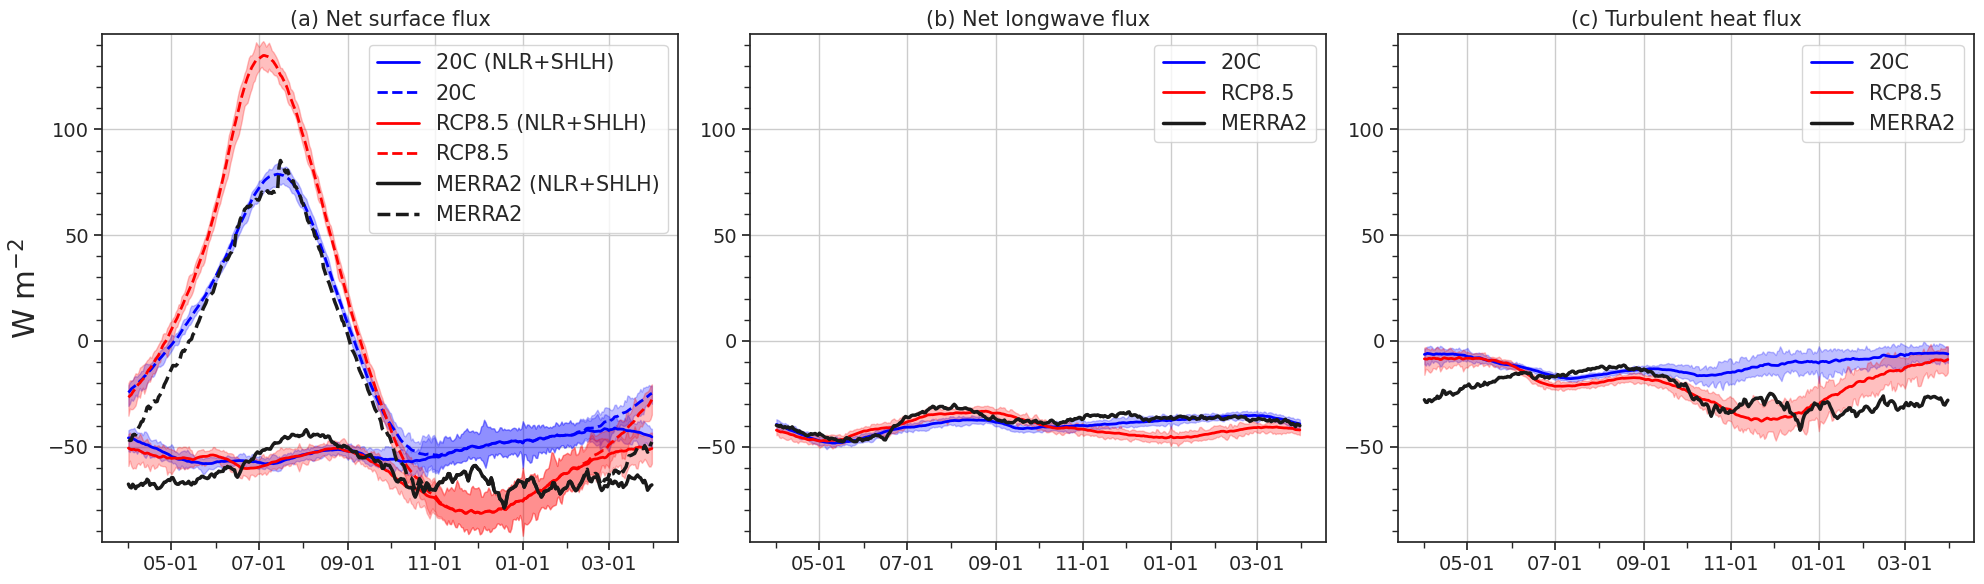

In [11]:
fig = plt.figure( figsize=(20,6) )
gs = plt.GridSpec(1,3,
                       width_ratios=[1,1,1],
                       height_ratios=[1]
                       )


ax = fig.add_subplot(gs[0])
c_year = pd.date_range('1999-4-01','2000-3-31')
ax.plot(c_year,(NSF_H).groupby('time.dayofyear').mean(['time','member_id']).roll(dayofyear=276,roll_coords=False),color='blue',lw=2,label='20C (NLR+SHLH)')
ax.plot(c_year,(NLR_H+SHLH_H+ASR_H).groupby('time.dayofyear').mean(['time','member_id']).roll(dayofyear=276,roll_coords=False),color='blue',ls='--',lw=2,label='20C')
ax.fill_between(c_year,(NSF_H).groupby('time.dayofyear').mean('time').quantile(0,'member_id').roll(dayofyear=276,roll_coords=False),
                 (NSF_H).groupby('time.dayofyear').mean('time').quantile(1,'member_id').roll(dayofyear=276,roll_coords=False),color='blue',alpha=.25)
ax.fill_between(c_year,(NLR_H+SHLH_H+ASR_H).groupby('time.dayofyear').mean('time').quantile(0,'member_id').roll(dayofyear=276,roll_coords=False),
                 (NLR_H+SHLH_H+ASR_H).groupby('time.dayofyear').mean('time').quantile(1,'member_id').roll(dayofyear=276,roll_coords=False),color='blue',alpha=.25)
ax.plot(c_year,(NSF_F).groupby('time.dayofyear').mean(['time','member_id']).roll(dayofyear=276,roll_coords=False),color='red',lw=2,label='RCP8.5 (NLR+SHLH)')
ax.plot(c_year,(NLR_F+SHLH_F+ASR_F).groupby('time.dayofyear').mean(['time','member_id']).roll(dayofyear=276,roll_coords=False),color='red',ls='--',lw=2,label='RCP8.5')
ax.fill_between(c_year,(NSF_F).groupby('time.dayofyear').mean('time').quantile(0,'member_id').roll(dayofyear=276,roll_coords=False),
                 (NSF_F).groupby('time.dayofyear').mean('time').quantile(1,'member_id').roll(dayofyear=276,roll_coords=False),color='red',alpha=.25)
ax.fill_between(c_year,(NLR_F+SHLH_F+ASR_F).groupby('time.dayofyear').mean('time').quantile(0,'member_id').roll(dayofyear=276,roll_coords=False),
                 (NLR_F+SHLH_F+ASR_F).groupby('time.dayofyear').mean('time').quantile(1,'member_id').roll(dayofyear=276,roll_coords=False),color='red',alpha=.25)
ax.plot(c_year,(Mclim_9005.NLR+Mclim_9005.SHLH).roll(dayofyear=276,roll_coords=False),color='k',lw=2.5,ls='-',label='MERRA2 (NLR+SHLH)')
ax.plot(c_year,(Mclim_9005.NLR+Mclim_9005.SHLH+Mclim_9005.ASR).roll(dayofyear=276,roll_coords=False),color='k',lw=2.5,ls='--',label='MERRA2')
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax.tick_params(which='major',labelsize=14)
ax.set_yticks(np.arange(-90,150,10),minor=True)
ax.grid()

ax2 = fig.add_subplot(gs[1])
ax2.plot(c_year,(NLR_H).groupby('time.dayofyear').mean(['time','member_id']).roll(dayofyear=276,roll_coords=False),color='blue',lw=2,label='20C')
ax2.fill_between(c_year,(NLR_H).groupby('time.dayofyear').mean('time').quantile(0,'member_id').roll(dayofyear=276,roll_coords=False),
                 (NLR_H).groupby('time.dayofyear').mean('time').quantile(1,'member_id').roll(dayofyear=276,roll_coords=False),color='blue',alpha=.25)                
ax2.plot(c_year,(NLR_F).groupby('time.dayofyear').mean(['time','member_id']).roll(dayofyear=276,roll_coords=False),color='red',lw=2,label='RCP8.5')
ax2.fill_between(c_year,(NLR_F).groupby('time.dayofyear').mean('time').quantile(0,'member_id').roll(dayofyear=276,roll_coords=False),
                 (NLR_F).groupby('time.dayofyear').mean('time').quantile(1,'member_id').roll(dayofyear=276,roll_coords=False),color='red',alpha=.25)  
ax2.plot(c_year,(Mclim_9005.NLR).roll(dayofyear=276,roll_coords=False),color='k',lw=2.5,ls='-',label='MERRA2')
ax2.xaxis.set_major_formatter(date_form)
ax2.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax2.tick_params(which='major',labelsize=14)
ax2.set_yticks(np.arange(-90,150,10),minor=True)
ax2.grid()

ax3 = fig.add_subplot(gs[2])
ax3.plot(c_year,(SHLH_H).groupby('time.dayofyear').mean(['time','member_id']).roll(dayofyear=276,roll_coords=False),color='blue',lw=2,label='20C')
ax3.fill_between(c_year,(SHLH_H).groupby('time.dayofyear').mean('time').quantile(0,'member_id').roll(dayofyear=276,roll_coords=False),
                 (SHLH_H).groupby('time.dayofyear').mean('time').quantile(1,'member_id').roll(dayofyear=276,roll_coords=False),color='blue',alpha=.25)
ax3.plot(c_year,(SHLH_F).groupby('time.dayofyear').mean(['time','member_id']).roll(dayofyear=276,roll_coords=False),color='red',lw=2,label='RCP8.5')
ax3.fill_between(c_year,(SHLH_F).groupby('time.dayofyear').mean('time').quantile(0,'member_id').roll(dayofyear=276,roll_coords=False),
                 (SHLH_F).groupby('time.dayofyear').mean('time').quantile(1,'member_id').roll(dayofyear=276,roll_coords=False),color='red',alpha=.25)

ax3.plot(c_year,(Mclim_9005.SHLH).roll(dayofyear=276,roll_coords=False),color='k',lw=2.5,ls='-',label='MERRA2')
ax3.xaxis.set_major_formatter(date_form)
ax3.xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
ax3.tick_params(which='major',labelsize=14)
ax3.set_yticks(np.arange(-90,150,10),minor=True)
ax3.grid()

ax.set_ybound(-95,145)
ax2.set_ybound(-95,145)
ax3.set_ybound(-95,145)
ax.legend(fontsize=15)
ax2.legend(fontsize=15)
ax3.legend(fontsize=15)

ax.set_title('(a) Net surface flux',fontsize=15)
ax2.set_title('(b) Net longwave flux',fontsize=15)
ax3.set_title('(c) Turbulent heat flux',fontsize=15)
ax.set_ylabel('W m$^{-2}$',fontsize=22)
fig.tight_layout()
#plt.savefig('sfcFlux.pdf', bbox_inches='tight')

## 3. The surface heating efficiency of $F_{\mathrm{trop}}$ events
---

This section includes code for reproducing Figures 2, S3, and S4.
- Figure 2: Composite of time-integrated MSE and surface flux anomalies during 20C $F_{\mathrm{trop}}$ events 
- Figure S3: Seasonality of event counts in 20C and RCP8.5 ensembles
- Figure S4: Change in the $F_{\mathrm{trop}}$ event composite (like Figure 2, but for all events) from the 20C to RCP8.5 ensemble

### Calculate the surface heating efficiency ($E_{\mathrm{trop}}$)

In [12]:
E_tropF = ((NSF_anomF)/
            ((ufunc2(NTES_anomF,comp.low_filt)))).sel(time=winter_F)

E_tropH = ((NSF_anomH)/
            ((ufunc2(NTES_anomH,comp.low_filt)))).sel(time=winter_H)

### Identify $F_{\mathrm{trop}}$ events and calculate mean $E_{\mathrm{trop}}$ during events

In [13]:
def events_by_member(m=0,MSE=MSE_F.sel(time=winter_F),dhmdt=dhmdt_F.sel(time=winter_F)
                     ,NLR=NLR_F.sel(time=winter_F),SHLH=SHLH_F.sel(time=winter_F)):
    MSE_anom = (MSE.isel(member_id=m).fillna(0))
    dhmdt_anom = (dhmdt.isel(member_id=m).fillna(0))
    NLR_anom = (NLR.isel(member_id=m).fillna(0))
    SHLH_anom = (SHLH.isel(member_id=m).fillna(0))
    NTES = ufunc2(comp.integrate_trop((MSE_anom*C/A) - (dhmdt_anom/sid)),comp.low_filt)
    E_trop = ((NLR_anom+SHLH_anom)/(NTES))
    
    extra_nan=NLR_anom.where(np.logical_and(NLR_anom.time.dt.month==11
                                            ,NLR_anom.time.dt.day==1)).dropna('time')*np.nan
    extra_nan['time'] = (extra_nan.time-np.array(1, dtype='timedelta64[D]'))

    E_trop_w = E_trop
    E_trop_w = xr.concat([E_trop_w,extra_nan],'time').sortby('time')
    NTES2 = xr.concat([NTES,extra_nan],'time').sortby('time')
    NSF = (NLR_anom+SHLH_anom)
    NSF2 = xr.concat([NSF,extra_nan],'time').sortby('time')

    eff,size=comp.event_average(E_trop_w,comp.event_days(sigma=0,array=NTES2))
    source,source_full=comp.event_integ(NTES2,comp.event_days(sigma=0,array=NTES2))
    eff_full=eff
    eff=eff.sel(time=source.time)
    eff
    return(eff)

<div class="alert alert-info">
    
<strong>Note:</strong> See *comp.functions.py* for more information on the method used to identify $F_{\mathrm{trop}}$ events.
</div>

In [14]:
E_eventH = xr.concat([events_by_member(m=m,MSE=MSE_anomH.sel(time=winter_H),dhmdt=dhmdt_anomH.sel(time=winter_H)
                     ,NLR=NLR_anomH.sel(time=winter_H),SHLH=SHLH_anomH.sel(time=winter_H)) for m in range(len(MSE_H.member_id))],'member_id')
E_eventF = xr.concat([events_by_member(m=m,MSE=MSE_anomF.sel(time=winter_F),dhmdt=dhmdt_anomF.sel(time=winter_F)
                     ,NLR=NLR_anomF.sel(time=winter_F),SHLH=SHLH_anomF.sel(time=winter_F)) for m in range(len(MSE_H.member_id))],'member_id')

### Define high, medium, and low-efficiency events

20C mean event $E_{\mathrm{trop}}$ (E_eventH) thresholds are used to separate events in 20C and RCP8.5 simulations

In [15]:
high_eff_timeH=E_eventH.where(E_eventH>=E_eventH.quantile(.75))
low_eff_timeH=E_eventH.where(E_eventH<=E_eventH.quantile(.25))
med_eff_timeH=E_eventH.where(np.logical_and(E_eventH>E_eventH.quantile(.25),E_eventH<E_eventH.quantile(.75)))

high_eff_timeF=E_eventF.where(E_eventF>=E_eventH.quantile(.75))
low_eff_timeF=E_eventF.where(E_eventF<=E_eventH.quantile(.25))
med_eff_timeF=E_eventF.where(np.logical_and(E_eventF>E_eventH.quantile(.25),E_eventF<E_eventH.quantile(.75)))

### Composite Analysis

Daily composites of the following list of variables in the 30 days before and after the central date of high, medium, and low-efficiency events.

In [16]:
list_H = [MSE_anomH, LH_anomH, NLR_anomH, SHLH_anomH, NSF_anomH, CRE_anomH, NTES_anomH, LTS_H]
list_F = [MSE_anomF, LH_anomF, NLR_anomF, SHLH_anomF, NSF_anomF, CRE_anomF, NTES_anomF, LTS_F]

In [17]:
[anom_MSE_comp_high_effH, anom_LH_comp_high_effH, anom_NLR_comp_high_effH, anom_SHLH_comp_high_effH,
anom_NSF_comp_high_effH, anom_CRE_comp_high_effH, anom_NTES_comp_high_effH, LTS_comp_high_effH] = [
    xr.concat([comp.composite((array.isel(member_id=m))
                               ,high_eff_timeH.sel(time=slice('1990-2-01','2005-12-01')).isel(member_id=m).dropna('time').time) 
               for m in range(len(NLR_H.member_id))],'member_id') for array in list_H]

[anom_MSE_comp_med_effH, anom_LH_comp_med_effH, anom_NLR_comp_med_effH, anom_SHLH_comp_med_effH,
anom_NSF_comp_med_effH, anom_CRE_comp_med_effH, anom_NTES_comp_med_effH, LTS_comp_med_effH] = [
    xr.concat([comp.composite((array.isel(member_id=m))
                               ,med_eff_timeH.sel(time=slice('1990-2-01','2005-12-01')).isel(member_id=m).dropna('time').time) 
               for m in range(len(NLR_H.member_id))],'member_id') for array in list_H]

[anom_MSE_comp_low_effH, anom_LH_comp_low_effH, anom_NLR_comp_low_effH, anom_SHLH_comp_low_effH,
anom_NSF_comp_low_effH, anom_CRE_comp_low_effH, anom_NTES_comp_low_effH, LTS_comp_low_effH] = [
    xr.concat([comp.composite((array.isel(member_id=m))
                               ,low_eff_timeH.sel(time=slice('1990-2-01','2005-12-01')).isel(member_id=m).dropna('time').time) 
               for m in range(len(NLR_H.member_id))],'member_id') for array in list_H]

[anom_MSE_comp_all_effH, anom_LH_comp_all_effH, anom_NLR_comp_all_effH, anom_SHLH_comp_all_effH,
anom_NSF_comp_all_effH, anom_CRE_comp_all_effH, anom_NTES_comp_all_effH, LTS_comp_all_effH] = [
    xr.concat([comp.composite((array.isel(member_id=m))
                               ,E_eventH.sel(time=slice('1990-2-01','2005-12-01')).isel(member_id=m).dropna('time').time) 
               for m in range(len(NLR_H.member_id))],'member_id') for array in list_H]

In [18]:
[anom_MSE_comp_high_effF, anom_LH_comp_high_effF, anom_NLR_comp_high_effF, anom_SHLH_comp_high_effF,
anom_NSF_comp_high_effF, anom_CRE_comp_high_effF, anom_NTES_comp_high_effF, LTS_comp_high_effF] = [
    xr.concat([comp.composite((array.isel(member_id=m))
                               ,high_eff_timeF.sel(time=slice('2071-2-02','2080-12-01')).isel(member_id=m).dropna('time').time) 
               for m in range(len(NLR_F.member_id))],'member_id') for array in list_F]

[anom_MSE_comp_med_effF, anom_LH_comp_med_effF, anom_NLR_comp_med_effF, anom_SHLH_comp_med_effF,
anom_NSF_comp_med_effF, anom_CRE_comp_med_effF, anom_NTES_comp_med_effF, LTS_comp_med_effF] = [
    xr.concat([comp.composite((array.isel(member_id=m))
                               ,med_eff_timeF.sel(time=slice('2071-2-02','2080-12-01')).isel(member_id=m).dropna('time').time) 
               for m in range(len(NLR_F.member_id))],'member_id') for array in list_F]

[anom_MSE_comp_low_effF, anom_LH_comp_low_effF, anom_NLR_comp_low_effF, anom_SHLH_comp_low_effF,
anom_NSF_comp_low_effF, anom_CRE_comp_low_effF, anom_NTES_comp_low_effF, LTS_comp_low_effF] = [
    xr.concat([comp.composite((array.isel(member_id=m))
                               ,low_eff_timeF.sel(time=slice('2071-2-02','2080-12-01')).isel(member_id=m).dropna('time').time) 
               for m in range(len(NLR_F.member_id))],'member_id') for array in list_F]

[anom_MSE_comp_all_effF, anom_LH_comp_all_effF, anom_NLR_comp_all_effF, anom_SHLH_comp_all_effF,
anom_NSF_comp_all_effF, anom_CRE_comp_all_effF, anom_NTES_comp_all_effF, LTS_comp_all_effF] = [
    xr.concat([comp.composite((array.isel(member_id=m))
                               ,E_eventF.sel(time=slice('2071-2-02','2080-12-01')).isel(member_id=m).dropna('time').time) 
               for m in range(len(NLR_F.member_id))],'member_id') for array in list_F]

### Perform T-tests

Test where the local MSE and LH flux convergence anomalies in high and medium-efficiency events are significantly diffferent from low-efficiency events 

In [19]:
ttest_highH = sp.ttest_ind(((anom_MSE_comp_high_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s')*10**-6),
((anom_MSE_comp_low_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s')*10**-6)).pvalue

ttest_medH = sp.ttest_ind(((anom_MSE_comp_med_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s')*10**-6),
((anom_MSE_comp_low_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s')*10**-6)).pvalue

ttest_highLH = sp.ttest_ind(((anom_LH_comp_high_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s')*10**-6),
((anom_LH_comp_low_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s')*10**-6)).pvalue

ttest_medLH = sp.ttest_ind(((anom_LH_comp_med_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s')*10**-6),
((anom_LH_comp_low_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s')*10**-6)).pvalue

Test where the change in the local MSE and LH flux convergence anomalies in events are significantly diffferent from 0

In [20]:
ttest_allH = sp.ttest_1samp((((anom_MSE_comp_all_effF-anom_MSE_comp_all_effH).assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s')*10**-6),0).pvalue

ttest_allLH = sp.ttest_1samp((((anom_LH_comp_all_effF-anom_LH_comp_all_effH).assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s')*10**-6),0).pvalue

### Figure 2


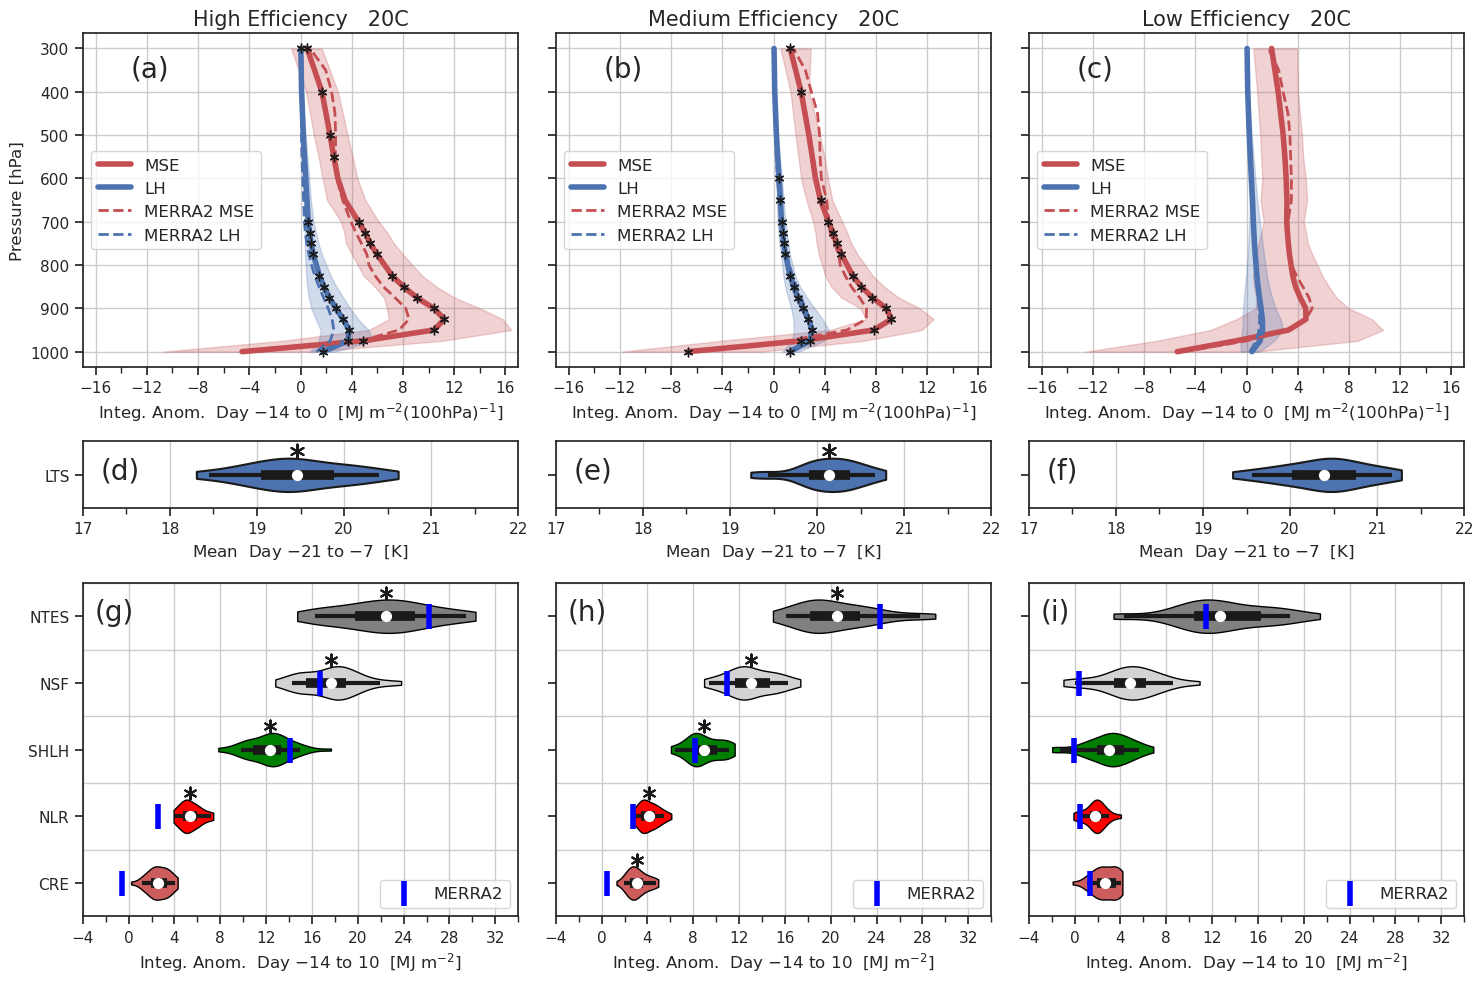

In [21]:
fig = plt.figure( figsize=(15,10) )
gs = plt.GridSpec(3, 3,
                       width_ratios=[1,1,1],
                       height_ratios=[1,.2,1]
                       )
ax = fig.add_subplot(gs[0])
((anom_MSE_comp_high_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').mean('member_id')*10**-6).plot(ax=ax,yincrease=False,y='plev',c='r',lw=4,label='MSE')

ax.fill_betweenx(MSE_anomH.sel(plev=slice(30000,100000)).plev,((anom_MSE_comp_high_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(0,'member_id')*10**-6),
               ((anom_MSE_comp_high_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(1,'member_id')*10**-6),alpha=.25,color='r')

((anom_LH_comp_high_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').mean('member_id')*10**-6).plot(ax=ax,yincrease=False,y='plev',c='b',lw=4,label='LH')

ax.fill_betweenx(MSE_anomH.sel(plev=slice(30000,100000)).plev,((anom_LH_comp_high_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(0,'member_id')*10**-6),
               ((anom_LH_comp_high_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(1,'member_id')*10**-6),alpha=.25,color='b')

Mflux_comp_9005.MSE_high.plot(ax=ax,yincrease=False,y='lev',c='r',ls='--',lw=2,label='MERRA2 MSE')
Mflux_comp_9005.LH_high.plot(ax=ax,yincrease=False,y='lev',c='b',ls='--',lw=2,label='MERRA2 LH')

(((anom_MSE_comp_high_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').mean('member_id')*10**-6)
.where(ttest_highH<.05)).plot(ax=ax,yincrease=False,y='plev',c='k',lw=2,marker=(6,2,0),ls='',ms=7)

(((anom_LH_comp_high_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').mean('member_id')*10**-6)
.where(ttest_highLH<.05)).plot(ax=ax,yincrease=False,y='plev',c='k',lw=2,marker=(6,2,0),ls='',ms=7)

ax.set_xlabel('Integ. Anom.  Day $-14$ to 0  [MJ m$^{-2}$(100hPa)$^{-1}$]',fontsize=12)
ax.set_xticks(np.arange(-16,20,4),minor=False),ax.set_xticks(np.arange(-16,18,2),minor=True)

ax2 = fig.add_subplot(gs[1])
((anom_MSE_comp_med_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').mean('member_id')*10**-6).plot(ax=ax2,yincrease=False,y='plev',c='r',lw=4,label='MSE')

ax2.fill_betweenx(MSE_anomH.sel(plev=slice(30000,100000)).plev,((anom_MSE_comp_med_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(0,'member_id')*10**-6),
               ((anom_MSE_comp_med_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(1,'member_id')*10**-6),alpha=.25,color='r')

((anom_LH_comp_med_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').mean('member_id')*10**-6).plot(ax=ax2,yincrease=False,y='plev',c='b',lw=4,label='LH')

ax2.fill_betweenx(MSE_anomH.sel(plev=slice(30000,100000)).plev,((anom_LH_comp_med_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(0,'member_id')*10**-6),
               ((anom_LH_comp_med_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(1,'member_id')*10**-6),alpha=.25,color='b')

Mflux_comp_9005.MSE_med.plot(ax=ax2,yincrease=False,y='lev',c='r',ls='--',lw=2,label='MERRA2 MSE')
Mflux_comp_9005.LH_med.plot(ax=ax2,yincrease=False,y='lev',c='b',ls='--',lw=2,label='MERRA2 LH')

(((anom_MSE_comp_med_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').mean('member_id')*10**-6)
.where(ttest_medH<.05)).plot(ax=ax2,yincrease=False,y='plev',c='k',lw=2,marker=(6,2,0),ls='',ms=7)

(((anom_LH_comp_med_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').mean('member_id')*10**-6)
.where(ttest_medLH<.05)).plot(ax=ax2,yincrease=False,y='plev',c='k',lw=2,marker=(6,2,0),ls='',ms=7)

ax2.set_xlabel('Integ. Anom.  Day $-14$ to 0  [MJ m$^{-2}$(100hPa)$^{-1}$]',fontsize=12)
ax2.set_xticks(np.arange(-16,20,4),minor=False),ax2.set_xticks(np.arange(-16,18,2),minor=True)

ax3 = fig.add_subplot(gs[2])
((anom_MSE_comp_low_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').mean('member_id')*10**-6).plot(ax=ax3,yincrease=False,y='plev',c='r',lw=4,label='MSE')

ax3.fill_betweenx(MSE_anomH.sel(plev=slice(30000,100000)).plev,((anom_MSE_comp_low_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(0,'member_id')*10**-6),
               ((anom_MSE_comp_low_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(1,'member_id')*10**-6),alpha=.25,color='r')

((anom_LH_comp_low_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').mean('member_id')*10**-6).plot(ax=ax3,yincrease=False,y='plev',c='b',lw=4,label='LH')

ax3.fill_betweenx(MSE_anomH.sel(plev=slice(30000,100000)).plev,((anom_LH_comp_low_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(0,'member_id')*10**-6),
               ((anom_LH_comp_low_effH.assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(1,'member_id')*10**-6),alpha=.25,color='b')

Mflux_comp_9005.MSE_low.plot(ax=ax3,yincrease=False,y='lev',c='r',ls='--',lw=2,label='MERRA2 MSE')
Mflux_comp_9005.LH_low.plot(ax=ax3,yincrease=False,y='lev',c='b',ls='--',lw=2,label='MERRA2 LH')

ax3.set_xlabel('Integ. Anom.  Day $-14$ to 0  [MJ m$^{-2}$(100hPa)$^{-1}$]',fontsize=12)
ax3.set_xticks(np.arange(-16,20,4),minor=False),ax3.set_xticks(np.arange(-16,18,2),minor=True)

ax5 = fig.add_subplot(gs[3])
parts = ax5.violinplot(LTS_comp_high_effH.sel(time=slice(9,24)).mean('time'),showmeans=False, showmedians=False,
        showextrema=False,vert=False)
for pc in parts['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('k')
    pc.set_linewidth(1.5)
    pc.set_alpha(1)
qmin, quartile1, medians, quartile3, qmax = np.percentile([LTS_comp_high_effH.sel(time=slice(9,24)).mean('time')], [5, 25, 50, 75, 95], axis=1)
means = np.mean([LTS_comp_high_effH.sel(time=slice(9,24)).mean('time')],axis=1)
inds = np.arange(1, len(medians) + 1)
ax5.scatter(means, inds, marker='o', color='white', s=50, zorder=3)
ax5.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=7)
ax5.hlines(inds, qmin, qmax, color='k', linestyle='-', lw=3)
ax5.set_yticks([1]),ax5.set_yticklabels(['LTS']),ax5.grid(axis='x'),ax5.set_xlabel('Mean  Day $-21$ to $-7$  [K]'),ax5.set_xticks(np.arange(14,23,1))
ax5.scatter(np.where(sp.ttest_ind([LTS_comp_low_effH.sel(time=slice(9,24)).mean('time')],[LTS_comp_high_effH.sel(time=slice(9,24)).mean('time')]
                                  ,axis=1).pvalue<.05,means,np.nan), inds+.35, marker=(6, 2, 0), color='k', s=100, zorder=3)

ax6 = fig.add_subplot(gs[4])
parts = ax6.violinplot(LTS_comp_med_effH.sel(time=slice(9,24)).mean('time'),showmeans=False, showmedians=False,
        showextrema=False,vert=False)
for pc in parts['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('k')
    pc.set_linewidth(1.5)
    pc.set_alpha(1)
qmin, quartile1, medians, quartile3, qmax = np.percentile([LTS_comp_med_effH.sel(time=slice(9,24)).mean('time')], [5, 25, 50, 75, 95], axis=1)
means = np.mean([LTS_comp_med_effH.sel(time=slice(9,24)).mean('time')],axis=1)
inds = np.arange(1, len(medians) + 1)
ax6.scatter(means, inds, marker='o', color='white', s=50, zorder=3)
ax6.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=7)
ax6.hlines(inds, qmin, qmax, color='k', linestyle='-', lw=3)
ax6.set_yticks([1]),ax6.set_yticklabels(['']),ax6.grid(axis='x'),ax6.set_xlabel('Mean  Day $-21$ to $-7$  [K]'),ax6.set_xticks(np.arange(14,23,1))
ax6.scatter(np.where(sp.ttest_ind([LTS_comp_low_effH.sel(time=slice(9,24)).mean('time')],[LTS_comp_med_effH.sel(time=slice(9,24)).mean('time')]
                                  ,axis=1).pvalue<.05,means,np.nan), inds+.35, marker=(6, 2, 0), color='k', s=100, zorder=3)

ax7 = fig.add_subplot(gs[5])
parts = ax7.violinplot(LTS_comp_low_effH.sel(time=slice(9,24)).mean('time'),showmeans=False, showmedians=False,
        showextrema=False,vert=False)
for pc in parts['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('k')
    pc.set_linewidth(1.5)
    pc.set_alpha(1)
qmin, quartile1, medians, quartile3, qmax = np.percentile([LTS_comp_low_effH.sel(time=slice(9,24)).mean('time')], [5, 25, 50, 75, 95], axis=1)
means = np.mean([LTS_comp_low_effH.sel(time=slice(9,24)).mean('time')],axis=1)
inds = np.arange(1, len(medians) + 1)
ax7.scatter(means, inds, marker='o', color='white', s=50, zorder=3)
ax7.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=7)
ax7.hlines(inds, qmin, qmax, color='k', linestyle='-', lw=3)
ax7.set_yticks([1]),ax7.set_yticklabels(['']),ax7.grid(axis='x'),ax7.set_xlabel('Mean  Day $-21$ to $-7$  [K]'),ax7.set_xticks(np.arange(14,23,1))

ax9 = fig.add_subplot(gs[6])
data= [integ.cumtrapz((anom_CRE_comp_high_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_NLR_comp_high_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_SHLH_comp_high_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_NSF_comp_high_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_NTES_comp_high_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6]
data_low= [integ.cumtrapz((anom_CRE_comp_low_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_NLR_comp_low_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_SHLH_comp_low_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_NSF_comp_low_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_NTES_comp_low_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6]
parts = ax9.violinplot(data,showmeans=False, showmedians=False,
        showextrema=False,vert=False)
colors = ["indianred", "red", "green", "lightgray", "gray"]
for pc,i in zip(parts['bodies'],colors):
    pc.set_facecolor([i])
    pc.set_edgecolor('black')
    pc.set_linewidth([1])
    pc.set_alpha(1)
qmin, quartile1, medians, quartile3, qmax = np.percentile(data, [5, 25, 50, 75, 95], axis=1)
means = np.mean(data,axis=1)
inds = np.arange(1, len(medians) + 1)
ax9.scatter(means, inds, marker='o', color='white', s=50, zorder=3)
ax9.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=7)
ax9.hlines(inds, qmin, qmax, color='k', linestyle='-', lw=3)
ax9.set_xticks(np.arange(-4,36,4),minor=False),ax9.set_yticks([1,2,3,4,5]),ax9.set_yticks([.5,1.5,2.5,3.5,4.5,5.5],minor=True)
ax9.set_xticks(np.arange(-4,36,2),minor=True)
ax9.set_yticklabels(['CRE','NLR','SHLH','NSF','NTES'])
ax9.grid(axis='x',which='major'),ax9.grid(axis='y',which='minor'),ax9.set_xlabel('Integ. Anom.  Day $-14$ to 10  [MJ m$^{-2}$]')
ax9.plot([Msfc_comp_9005.CRE_high,Msfc_comp_9005.NLR_high,Msfc_comp_9005.SHLH_high,
          Msfc_comp_9005.NSF_high,Msfc_comp_9005.NTES_high],inds, marker='|',ms=18,zorder=3,markeredgecolor='blue',markerfacecolor='blue',markeredgewidth=4,ls='',label='MERRA2')
ax9.scatter(np.where(sp.ttest_ind(data_low,data,axis=1).pvalue<.05,means,np.nan), inds+.35, marker=(6, 2, 0), color='k', s=75, zorder=3)
ax9.legend(fontsize=12,loc='lower right')

ax10 = fig.add_subplot(gs[7])
data= [integ.cumtrapz((anom_CRE_comp_med_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_NLR_comp_med_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_SHLH_comp_med_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_NSF_comp_med_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_NTES_comp_med_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6]
parts = ax10.violinplot(data,showmeans=False, showmedians=False,
        showextrema=False,vert=False)
colors = ["indianred", "red", "green", "lightgray", "gray"]
for pc,i in zip(parts['bodies'],colors):
    pc.set_facecolor([i])
    pc.set_edgecolor('black')
    pc.set_linewidth(1)
    pc.set_alpha(1)
qmin, quartile1, medians, quartile3, qmax = np.percentile(data, [5, 25, 50, 75, 95], axis=1)
means = np.mean(data,axis=1)
inds = np.arange(1, len(medians) + 1)
ax10.scatter(means, inds, marker='o', color='white', s=50, zorder=3)
ax10.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=7)
ax10.hlines(inds, qmin, qmax, color='k', linestyle='-', lw=3)
ax10.set_xticks(np.arange(-4,36,4),minor=False),ax10.set_yticks([1,2,3,4,5]),ax10.set_yticks([.5,1.5,2.5,3.5,4.5,5.5],minor=True)
ax10.set_xticks(np.arange(-4,36,2),minor=True),ax10.set_yticklabels([])
ax10.grid(axis='x'),ax10.grid(axis='y',which='minor'),ax10.set_xlabel('Integ. Anom.  Day $-14$ to 10  [MJ m$^{-2}$]')
ax10.plot([Msfc_comp_9005.CRE_med,Msfc_comp_9005.NLR_med,Msfc_comp_9005.SHLH_med,
          Msfc_comp_9005.NSF_med,Msfc_comp_9005.NTES_med],inds, marker='|',ms=18,zorder=3,markeredgecolor='blue',markerfacecolor='blue',markeredgewidth=4,ls='',label='MERRA2')
ax10.scatter(np.where(sp.ttest_ind(data_low,data,axis=1).pvalue<.05,means,np.nan), inds+.35, marker=(6, 2, 0), color='k', s=75, zorder=3)
ax10.legend(fontsize=12,loc='lower right')

ax11 = fig.add_subplot(gs[8])
data=[integ.cumtrapz((anom_CRE_comp_low_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_NLR_comp_low_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_SHLH_comp_low_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_NSF_comp_low_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz((anom_NTES_comp_low_effH[:,16:42]),dx=sid,initial=0)[:,25]*10**-6]
parts = ax11.violinplot(data,showmeans=False, showmedians=False,
        showextrema=False,vert=False)
colors = ["indianred", "red", "green", "lightgray", "gray"]
for pc,i in zip(parts['bodies'],colors):
    pc.set_facecolor([i])
    pc.set_edgecolor('black')
    pc.set_linewidth(1)
    pc.set_alpha(1)
qmin, quartile1, medians, quartile3, qmax = np.percentile(data, [5, 25, 50, 75, 95], axis=1)
means = np.mean(data,axis=1)
inds = np.arange(1, len(medians) + 1)
ax11.scatter(means, inds, marker='o', color='white', s=50, zorder=3)
ax11.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=7)
ax11.hlines(inds, qmin, qmax, color='k', linestyle='-', lw=3)
ax11.set_xticks(np.arange(-4,36,4),minor=False),ax11.set_yticks([1,2,3,4,5]),ax11.set_yticks([.5,1.5,2.5,3.5,4.5,5.5],minor=True)
ax11.set_xticks(np.arange(-4,36,2),minor=True),ax11.set_yticklabels([])
ax11.grid(axis='x'),ax11.grid(axis='y',which='minor'),ax11.set_xlabel('Integ. Anom.  Day $-14$ to 10  [MJ m$^{-2}$]')
ax11.plot([Msfc_comp_9005.CRE_low,Msfc_comp_9005.NLR_low,Msfc_comp_9005.SHLH_low,
          Msfc_comp_9005.NSF_low,Msfc_comp_9005.NTES_low],inds, marker='|',ms=18,zorder=3,markeredgecolor='blue',markerfacecolor='blue',markeredgewidth=4,ls='',label='MERRA2')
ax11.legend(fontsize=12,loc='lower right')

ax.grid(),ax2.grid(),ax3.grid()
ax.set_xbound(-17,17),ax2.set_xbound(-17,17),ax3.set_xbound(-17,17)
ax5.set_xbound(17,22),ax6.set_xbound(17,22),ax7.set_xbound(17,22),ax9.set_xbound(-4,34),ax10.set_xbound(-4,34),ax11.set_xbound(-4,34)
ax5.set_ybound(.5,1.5),ax6.set_ybound(.5,1.5),ax7.set_ybound(.5,1.5)
ax9.set_ybound(.5,5.5),ax10.set_ybound(.5,5.5),ax11.set_ybound(.5,5.5)
ax.set_yticklabels(np.arange(200,1100,100)),ax2.set_yticklabels(['']),ax3.set_yticklabels([''])
ax.set_ylabel('Pressure [hPa]'),ax2.set_ylabel(''),ax3.set_ylabel('');
ax.legend(fontsize=12,loc='center left'),ax2.legend(fontsize=12,loc='center left'),ax3.legend(fontsize=12,loc='center left')
ax5.set_xticks(np.arange(17,22.5,.5),minor=True),ax6.set_xticks(np.arange(17,22.5,.5),minor=True),ax7.set_xticks(np.arange(17,22.5,.5),minor=True)
ax.set_title('High Efficiency   20C',fontsize=15),ax2.set_title('Medium Efficiency   20C',fontsize=15),ax3.set_title('Low Efficiency   20C',fontsize=15)
ax9.tick_params(axis='y',which='minor',length=0),ax10.tick_params(axis='y',which='minor',length=0),ax11.tick_params(axis='y',which='minor',length=0)
ax.text(-13.25,36500,'(a)',fontsize=20);ax2.text(-13.25,36500,'(b)',fontsize=20);ax3.text(-13.25,36500,'(c)',fontsize=20)
ax5.text(17.2,.95,'(d)',fontsize=20);ax6.text(17.2,.95,'(e)',fontsize=20);ax7.text(17.2,.95,'(f)',fontsize=20)
ax9.text(-3,4.95,'(g)',fontsize=20);ax10.text(-3,4.95,'(h)',fontsize=20);ax11.text(-3,4.95,'(i)',fontsize=20)
fig.tight_layout()
#plt.savefig('eventAEB.pdf', bbox_inches='tight')

### Compute monthly seasonality of events and associated 95% mean confidence interval (MCI)

In [22]:
event_seasonality_H = pd.DataFrame({'High Efficiency':(high_eff_timeH.groupby('time.month').count()/1.6).mean('member_id').roll(month=2),
              'Medium Efficiency':(med_eff_timeH.groupby('time.month').count()/1.6).mean('member_id').roll(month=2),
              'Low Efficiency':(low_eff_timeH.groupby('time.month').count()/1.6).mean('member_id').roll(month=2)})

event_seasonality_F = pd.DataFrame({'High Efficiency':(high_eff_timeF.groupby('time.month').count()).mean('member_id').roll(month=2),
              'Medium Efficiency':(med_eff_timeF.groupby('time.month').count()).mean('member_id').roll(month=2),
              'Low Efficiency':(low_eff_timeF.groupby('time.month').count()).mean('member_id').roll(month=2)})

event_seasonality_H_mci = pd.DataFrame({'High Efficiency':comp.mci((high_eff_timeH.groupby('time.month').count()/1.6).roll(month=2)),
              'Medium Efficiency':comp.mci((med_eff_timeH.groupby('time.month').count()/1.6).roll(month=2)),
              'Low Efficiency':comp.mci((low_eff_timeH.groupby('time.month').count()/1.6).roll(month=2))})

event_seasonality_F_mci = pd.DataFrame({'High Efficiency':comp.mci((high_eff_timeF.groupby('time.month').count()).roll(month=2)),
              'Medium Efficiency':comp.mci((med_eff_timeF.groupby('time.month').count()).roll(month=2)),
              'Low Efficiency':comp.mci((low_eff_timeF.groupby('time.month').count()).roll(month=2))})

event_seasonality_diff_mci = pd.DataFrame({'High Efficiency':comp.mci((high_eff_timeF.groupby('time.month').count()).roll(month=2)-
                                                                (high_eff_timeH.groupby('time.month').count()).roll(month=2)),
              'Medium Efficiency':comp.mci((med_eff_timeF.groupby('time.month').count()).roll(month=2)-
                                     (med_eff_timeH.groupby('time.month').count()).roll(month=2)),
              'Low Efficiency':comp.mci((low_eff_timeF.groupby('time.month').count()).roll(month=2)-
                                  (low_eff_timeH.groupby('time.month').count()).roll(month=2))})

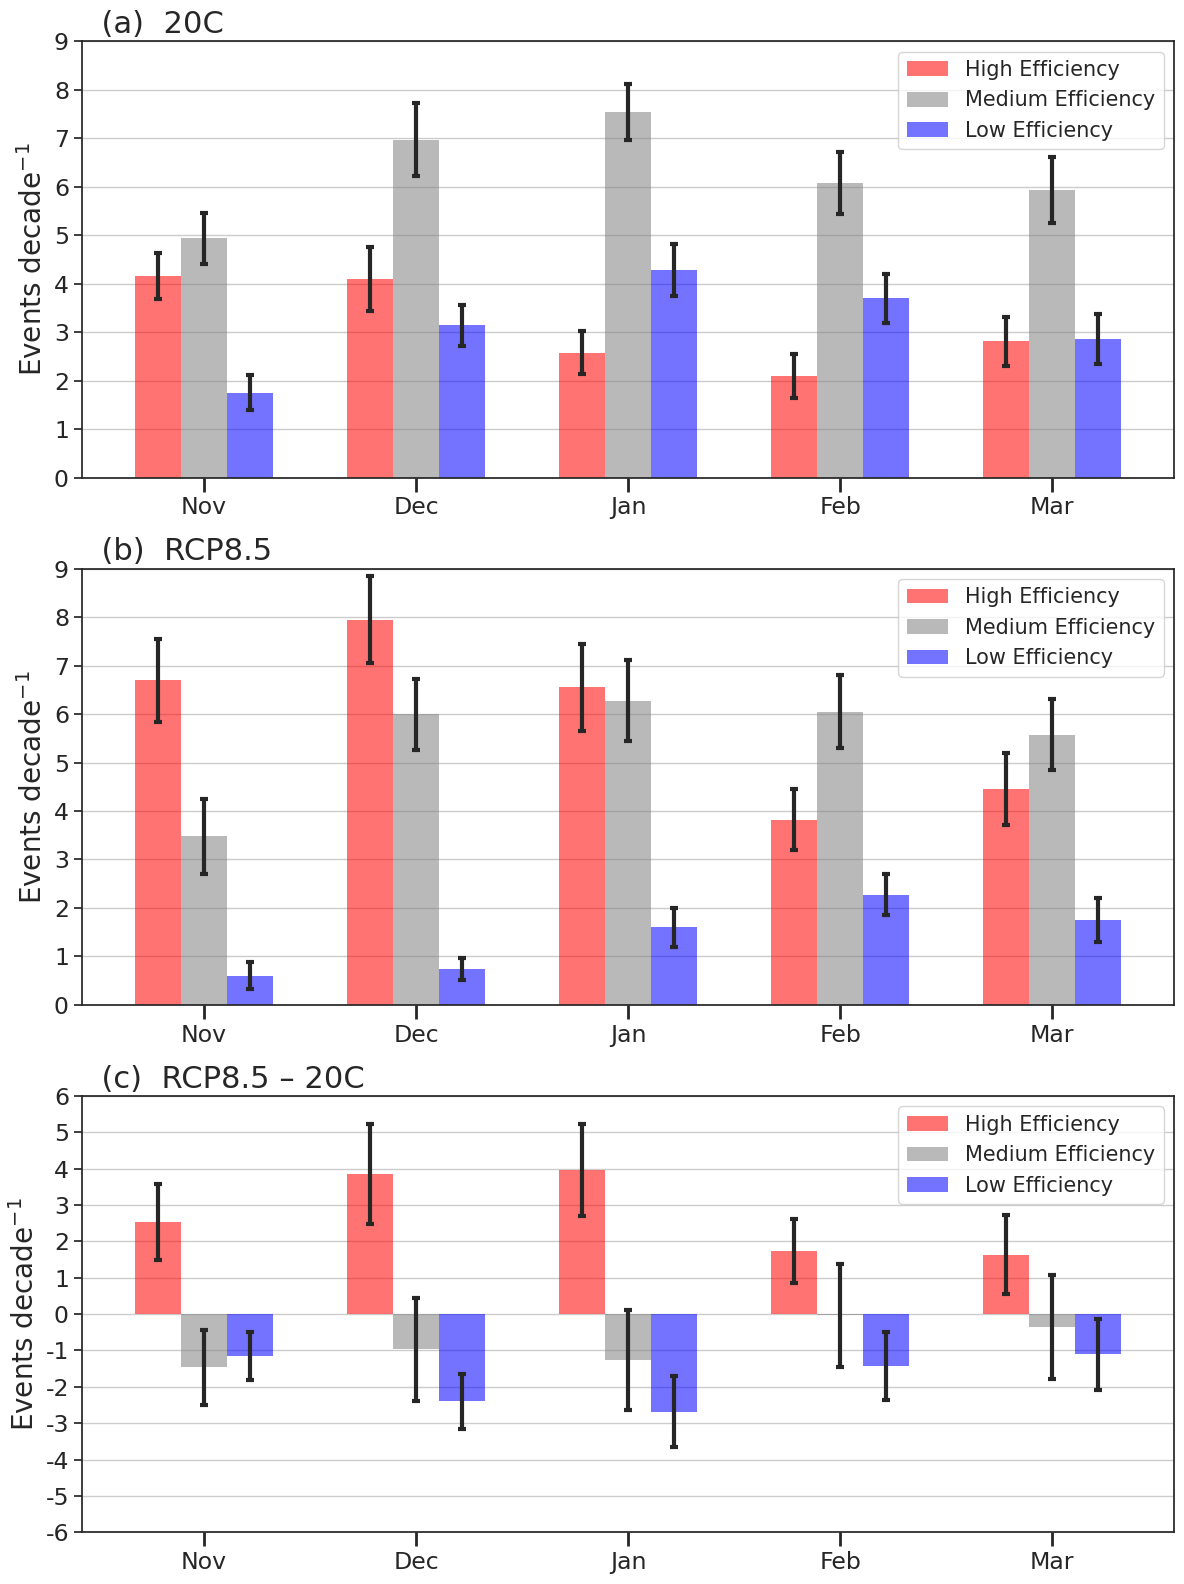

In [23]:
fig = plt.figure( figsize=(12,16) )
gs = plt.GridSpec(3,1,
                       width_ratios=[1],
                       height_ratios=[1,1,1]
                       )
ax = fig.add_subplot(gs[0])
(event_seasonality_H).plot.bar(width=.65,alpha=.55,color=['red','gray','blue'],edgecolor='gray',lw=0,ax=ax
                             ,yerr=event_seasonality_H_mci,error_kw={'elinewidth':3,'capsize':3,'capthick':3})
ax.grid(axis='y')
ax.set_ybound(0,9)
ax.legend(fontsize=15)
ax.set_xticklabels(['Nov','Dec','Jan','Feb','Mar'],rotation=0, fontsize=17)
ax.tick_params(axis='x',which='major',direction='out',length=10,width=2)
ax.set_yticklabels(np.arange(0,10,1),fontsize=17)
ax.set_ylabel('Events decade$^{-1}$',fontsize=20)

ax2 = fig.add_subplot(gs[1])
(event_seasonality_F).plot.bar(width=.65,alpha=.55,color=['red','gray','blue'],edgecolor='gray',lw=0,ax=ax2
                             ,yerr=event_seasonality_F_mci,error_kw={'elinewidth':3,'capsize':3,'capthick':3})
ax2.grid(axis='y')
ax2.set_ybound(0,9)
ax2.legend(fontsize=15)
ax2.set_xticklabels(['Nov','Dec','Jan','Feb','Mar'],rotation=0, fontsize=17)
ax2.tick_params(axis='x',which='major',direction='out',length=10,width=2)
ax2.set_yticklabels(np.arange(0,10,1),fontsize=17)
ax2.set_ylabel('Events decade$^{-1}$',fontsize=20)

ax3 = fig.add_subplot(gs[2])
(event_seasonality_F-event_seasonality_H).plot.bar(width=.65,alpha=.55,color=['red','gray','blue'],edgecolor='gray',lw=0,ax=ax3
                                               ,yerr=event_seasonality_diff_mci,error_kw={'elinewidth':3,'capsize':3,'capthick':3})
ax3.grid(axis='y')
ax3.set_ybound(-6,6)
ax3.legend(fontsize=15)
ax3.set_xticklabels(['Nov','Dec','Jan','Feb','Mar'],rotation=0, fontsize=17)
ax3.tick_params(axis='x',which='major',direction='out',length=10,width=2)
ax3.set_yticks(np.arange(-6,7,1))
ax3.set_yticklabels(np.arange(-6,7,1),fontsize=17)
ax3.set_ylabel('Events decade$^{-1}$',fontsize=20)

ax.set_title('  (a)  20C',fontsize=22,loc='left');ax2.set_title('  (b)  RCP8.5',fontsize=22,loc='left');ax3.set_title('  (c)  RCP8.5 – 20C',fontsize=22,loc='left')
fig.tight_layout()
#plt.savefig('EventSeasonality.pdf', bbox_inches='tight')

### Figure S4

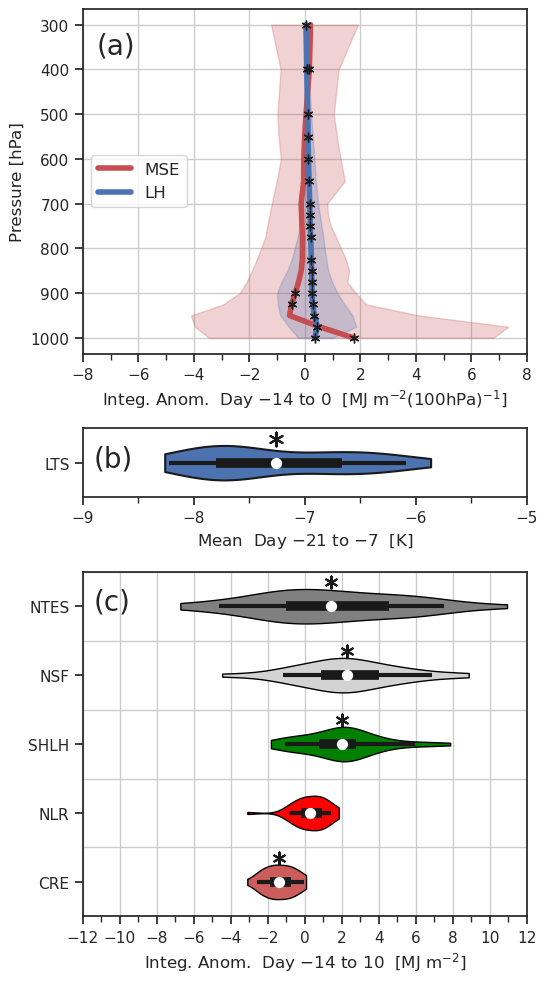

In [24]:
fig = plt.figure( figsize=(15,10) )
gs = plt.GridSpec(3, 3,
                       width_ratios=[1,1,1],
                       height_ratios=[1,.2,1]
                       )
ax = fig.add_subplot(gs[0])
(((anom_MSE_comp_all_effF-anom_MSE_comp_all_effH).assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').mean('member_id')*10**-6).plot(ax=ax,yincrease=False,y='plev',c='r',lw=4,label='MSE')

ax.fill_betweenx(MSE_anomH.sel(plev=slice(30000,100000)).plev,(((anom_MSE_comp_all_effF-anom_MSE_comp_all_effH).assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(0,'member_id')*10**-6),
               (((anom_MSE_comp_all_effF-anom_MSE_comp_all_effH).assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(1,'member_id')*10**-6),alpha=.25,color='r')

(((anom_LH_comp_all_effF-anom_LH_comp_all_effH).assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').mean('member_id')*10**-6).plot(ax=ax,yincrease=False,y='plev',c='b',lw=4,label='LH')

ax.fill_betweenx(MSE_anomH.sel(plev=slice(30000,100000)).plev,(((anom_LH_comp_all_effF-anom_LH_comp_all_effH).assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(0,'member_id')*10**-6),
               (((anom_LH_comp_all_effF-anom_LH_comp_all_effH).assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').quantile(1,'member_id')*10**-6),alpha=.25,color='b')

((((anom_MSE_comp_all_effF-anom_MSE_comp_all_effH).assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').mean('member_id')*10**-6)
.where(ttest_allH<.05)).plot(ax=ax,yincrease=False,y='plev',c='k',lw=2,marker=(6,2,0),ls='',ms=7)

((((anom_LH_comp_all_effF-anom_LH_comp_all_effH).assign_coords({'time': MSE_anomF.isel(time=slice(0,61)).time})*h()
    ).sel(plev=slice(30000,100000)).isel(time=slice(16,31)).integrate('time',datetime_unit='s').mean('member_id')*10**-6)
.where(ttest_allLH<.05)).plot(ax=ax,yincrease=False,y='plev',c='k',lw=2,marker=(6,2,0),ls='',ms=7)

ax.set_xlabel('Integ. Anom.  Day $-14$ to 0  [MJ m$^{-2}$(100hPa)$^{-1}$]',fontsize=12)
ax.set_xticks(np.arange(-10,12,2),minor=False),ax.set_xticks(np.arange(-10,11,1),minor=True)

ax5 = fig.add_subplot(gs[3])
parts = ax5.violinplot((LTS_comp_all_effF-LTS_comp_high_effH).sel(time=slice(9,24)).mean('time'),showmeans=False, showmedians=False,
        showextrema=False,vert=False)
for pc in parts['bodies']:
    pc.set_facecolor('b')
    pc.set_edgecolor('k')
    pc.set_linewidth(1.5)
    pc.set_alpha(1)
qmin, quartile1, medians, quartile3, qmax = np.percentile([(LTS_comp_all_effF-LTS_comp_high_effH).sel(time=slice(9,24)).mean('time')], [5, 25, 50, 75, 95], axis=1)
means = np.mean([(LTS_comp_all_effF-LTS_comp_high_effH).sel(time=slice(9,24)).mean('time')],axis=1)
inds = np.arange(1, len(medians) + 1)
ax5.scatter(means, inds, marker='o', color='white', s=50, zorder=3)
ax5.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=7)
ax5.hlines(inds, qmin, qmax, color='k', linestyle='-', lw=3)
ax5.set_yticks([1]),ax5.set_yticklabels(['LTS']),ax5.grid(axis='x'),ax5.set_xlabel('Mean  Day $-21$ to $-7$  [K]'),ax5.set_xticks(np.arange(-10,11,1))
ax5.set_xticks(np.arange(-10,10.5,.5),minor=True)
ax5.scatter(np.where(sp.ttest_1samp([(LTS_comp_all_effF-LTS_comp_high_effH).sel(time=slice(9,24)).mean('time')],0
                                  ,axis=1).pvalue<.05,means,np.nan), inds+.35, marker=(6, 2, 0), color='k', s=100, zorder=3)


ax9 = fig.add_subplot(gs[6])
data= [integ.cumtrapz(((anom_CRE_comp_all_effF-anom_CRE_comp_all_effH)[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz(((anom_NLR_comp_all_effF-anom_NLR_comp_all_effH)[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz(((anom_SHLH_comp_all_effF-anom_SHLH_comp_all_effH)[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz(((anom_NSF_comp_all_effF-anom_NSF_comp_all_effH)[:,16:42]),dx=sid,initial=0)[:,25]*10**-6,
               integ.cumtrapz(((anom_NTES_comp_all_effF-anom_NTES_comp_all_effH)[:,16:42]),dx=sid,initial=0)[:,25]*10**-6]
parts = ax9.violinplot(data,showmeans=False, showmedians=False,
        showextrema=False,vert=False)
colors = ["indianred", "red", "green", "lightgray", "gray"]
for pc,i in zip(parts['bodies'],colors):
    pc.set_facecolor([i])
    pc.set_edgecolor('black')
    pc.set_linewidth([1])
    pc.set_alpha(1)
qmin, quartile1, medians, quartile3, qmax = np.percentile(data, [5, 25, 50, 75, 95], axis=1)
means = np.mean(data,axis=1)
inds = np.arange(1, len(medians) + 1)
ax9.scatter(means, inds, marker='o', color='white', s=50, zorder=3)
ax9.hlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=7)
ax9.hlines(inds, qmin, qmax, color='k', linestyle='-', lw=3)
ax9.set_xticks(np.arange(-16,20,2),minor=False),ax9.set_yticks([1,2,3,4,5]),ax9.set_yticks([.5,1.5,2.5,3.5,4.5,5.5],minor=True)
ax9.set_xticks(np.arange(-16,18,1),minor=True)
ax9.set_yticklabels(['CRE','NLR','SHLH','NSF','NTES'])
ax9.grid(axis='x',which='major'),ax9.grid(axis='y',which='minor'),ax9.set_xlabel('Integ. Anom.  Day $-14$ to 10  [MJ m$^{-2}$]')
ax9.scatter(np.where(sp.ttest_1samp(data,0,axis=1).pvalue<.05,means,np.nan), inds+.35, marker=(6, 2, 0), color='k', s=75, zorder=3)

ax.grid(),ax5.grid(axis='x')
ax.set_xbound(-8,8)
ax5.set_xbound(-9,-5),ax9.set_xbound(-12,12)
ax5.set_ybound(.5,1.5)
ax9.set_ybound(.5,5.5)
ax.set_yticklabels(np.arange(200,1100,100))
ax.set_ylabel('Pressure [hPa]')
ax.legend(fontsize=12,loc='center left')
#ax.set_title('High Efficiency   20C',fontsize=15)
ax9.tick_params(axis='y',which='minor',length=0),
ax.text(-7.5,36500,'(a)',fontsize=20)
ax5.text(-8.9,.95,'(b)',fontsize=20)
ax9.text(-11.4,4.95,'(c)',fontsize=20)
fig.tight_layout()
#plt.savefig('deltaEventAEB.pdf', bbox_inches='tight')

## 4. Change in the winter-mean $E_{\mathrm{trop}}$ and surface warming implications
---

This section includes code for reproducing Figures 3, 4, S2.
- Figure 3: Winter mean change in the number of high, medium, and low-efficiency events per decade
- Figure 4: Winter mean change in $E_{\mathrm{trop}}$ and the contribution to the change in the NSF from changes in NTES and $E_{\mathrm{trop}}$
- Figure S2: Daily mean NSF against NTES and the linear regression in 20C and RCP8.5 ensembles for each winter month (the slope of the linear regression line is another interpretation of $E_{\mathrm{trop}}$)

### Figure 3

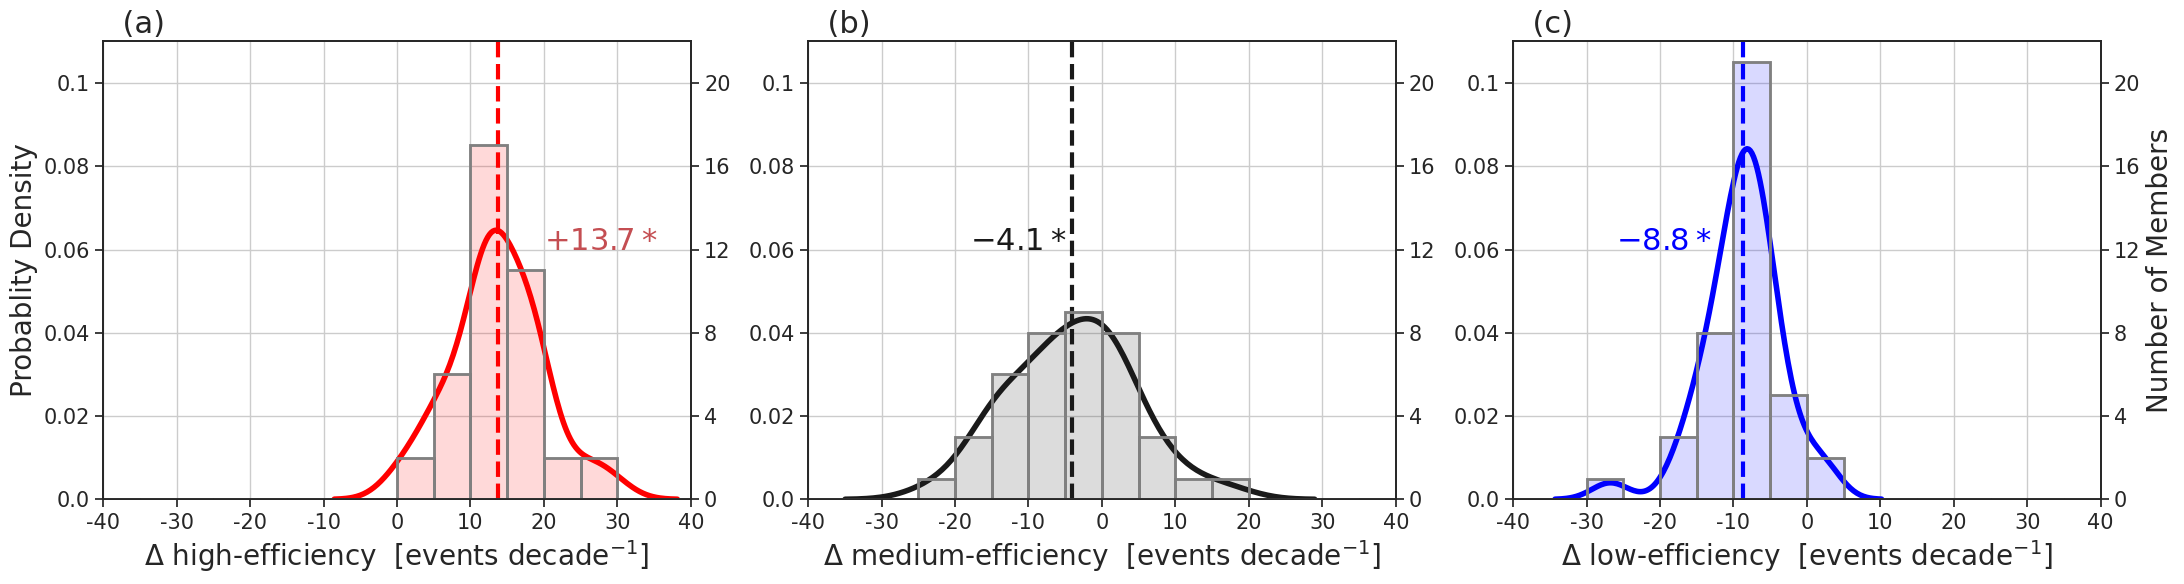

In [25]:
fig = plt.figure( figsize=(22,6) )
gs = plt.GridSpec(1,3,
                       width_ratios=[1,1,1],
                       height_ratios=[1]
                       )


ax = fig.add_subplot(gs[0])
ax2 = ax.twinx()
sns.kdeplot(((E_eventF.where(E_eventF>=E_eventH.quantile(.75))).count('time')/1.0)-((E_eventH.where(E_eventH>=E_eventH.quantile(.75))).count('time')/1.6),ax=ax,color='red',lw=4)
sns.histplot(((E_eventF.where(E_eventF>=E_eventH.quantile(.75))).count('time')/1.0)-((E_eventH.where(E_eventH>=E_eventH.quantile(.75))).count('time')/1.6),ax=ax2,alpha=.15,color='red',edgecolor='gray',lw=3,binrange=(-40,40),bins=16)

ax.axvline(((E_eventF.where(E_eventF>=E_eventH.quantile(.75))).count('time').mean()/1.0)-((E_eventH.where(E_eventH>=E_eventH.quantile(.75))).count('time').mean()/1.6),color='red',lw=3,ls='--')
ax.text(20,.06,'$+{:.1f}*$'.format((((E_eventF.where(E_eventF>=E_eventH.quantile(.75))).count('time').mean()/1.0)
-((E_eventH.where(E_eventH>=E_eventH.quantile(.75))).count('time').mean()/1.6))),color='r',fontsize=22)
ax.set_xlabel('$\Delta$ high-efficiency  [events decade$^{-1}$]',fontsize=20)
ax.set_ylabel('Probablity Density',fontsize=20)
ax2.set_ylabel('',fontsize=14)
ax.grid()

ax3 = fig.add_subplot(gs[2])
ax4 = ax3.twinx()
sns.kdeplot(((E_eventF.where(E_eventF<=E_eventH.quantile(.25))).count('time')/1.0)-((E_eventH.where(E_eventH<=E_eventH.quantile(.25))).count('time')/1.6),ax=ax3,color='blue',lw=4)
sns.histplot(((E_eventF.where(E_eventF<=E_eventH.quantile(.25))).count('time')/1.0)-((E_eventH.where(E_eventH<=E_eventH.quantile(.25))).count('time')/1.6),ax=ax4,alpha=.15,color='blue',edgecolor='gray',lw=3,binrange=(-40,40),bins=16)

ax3.axvline(((E_eventF.where(E_eventF<=E_eventH.quantile(.25))).count('time').mean()/1.0)-((E_eventH.where(E_eventH<=E_eventH.quantile(.25))).count('time').mean()/1.6),color='blue',lw=3,ls='--')
ax3.text(-26,.06,'${:.1f}*$'.format(((E_eventF.where(E_eventF<=E_eventH.quantile(.25))).count('time').mean()/1.0)
                                   -((E_eventH.where(E_eventH<=E_eventH.quantile(.25))).count('time').mean()/1.6)),color='blue',fontsize=22)
ax3.set_xlabel('$\Delta$ low-efficiency  [events decade$^{-1}$]',fontsize=20)
ax3.set_ylabel('',fontsize=14)
ax4.set_ylabel('Number of Members',fontsize=20)
ax3.grid()

ax5 = fig.add_subplot(gs[1])
ax6 = ax5.twinx()
sns.kdeplot(((E_eventF.where(np.logical_and(E_eventF>E_eventH.quantile(.25),E_eventF<E_eventH.quantile(.75)))).count('time')/1)-((E_eventH.where(np.logical_and(E_eventH>E_eventH.quantile(.25),E_eventH<E_eventH.quantile(.75)))).count('time')/1.6),ax=ax5,color='k',lw=4)
sns.histplot(((E_eventF.where(np.logical_and(E_eventF>E_eventH.quantile(.25),E_eventF<E_eventH.quantile(.75)))).count('time')/1)-((E_eventH.where(np.logical_and(E_eventH>E_eventH.quantile(.25),E_eventH<E_eventH.quantile(.75)))).count('time')/1.6),ax=ax6,alpha=.15,color='k',edgecolor='gray',lw=3,binrange=(-40,40),bins=16)

ax5.axvline(((E_eventF.where(np.logical_and(E_eventF>E_eventH.quantile(.25),E_eventF<E_eventH.quantile(.75)))).count('time').mean()/1.0)-((E_eventH.where(np.logical_and(E_eventH>E_eventH.quantile(.25),E_eventH<E_eventH.quantile(.75)))).count('time').mean()/1.6),color='k',lw=3,ls='--')
ax5.text(-18,.06,'${:.1f}*$'.format(((E_eventF.where(np.logical_and(E_eventF>E_eventH.quantile(.25),E_eventF<E_eventH.quantile(.75)))).count('time').mean()/1.0)
                                   -((E_eventH.where(np.logical_and(E_eventH>E_eventH.quantile(.25),E_eventH<E_eventH.quantile(.75)))).count('time').mean()/1.6)),color='k',fontsize=22)
ax5.set_xlabel('$\Delta$ medium-efficiency  [events decade$^{-1}$]',fontsize=20)
ax5.set_ylabel('',fontsize=14)
ax6.set_ylabel('',fontsize=16)
ax5.grid()

ax.set_xbound(-40,40)
ax3.set_xbound(-40,40)
ax5.set_xbound(-40,40)

ax.set_ybound(0,.11)
ax3.set_ybound(0,.11)
ax5.set_ybound(0,.11)

ax2.set_ybound(0,22)
ax4.set_ybound(0,22)
ax6.set_ybound(0,22)
ax2.set_yticks(np.arange(0,24,4));ax4.set_yticks(np.arange(0,24,4));ax6.set_yticks(np.arange(0,24,4))
ax.set_yticklabels(np.arange(0,.12,.02),fontsize=15);ax3.set_yticklabels(np.arange(0,.12,.02),fontsize=15)
ax5.set_yticklabels(np.arange(0,.12,.02),fontsize=15)
ax2.set_yticklabels(np.arange(0,24,4),fontsize=15);ax4.set_yticklabels(np.arange(0,24,4),fontsize=15)
ax6.set_yticklabels(np.arange(0,24,4),fontsize=15)
ax.set_xticklabels(np.arange(-40,50,10),fontsize=15);ax3.set_xticklabels(np.arange(-40,50,10),fontsize=15)
ax5.set_xticklabels(np.arange(-40,50,10),fontsize=15)
ax.set_title('  (a)',fontsize=22,loc='left');ax5.set_title('  (b)',fontsize=22,loc='left');ax3.set_title('  (c)',fontsize=22,loc='left')
fig.tight_layout()
#plt.savefig('deltaEvent.pdf', bbox_inches='tight')

### Figure 4

''

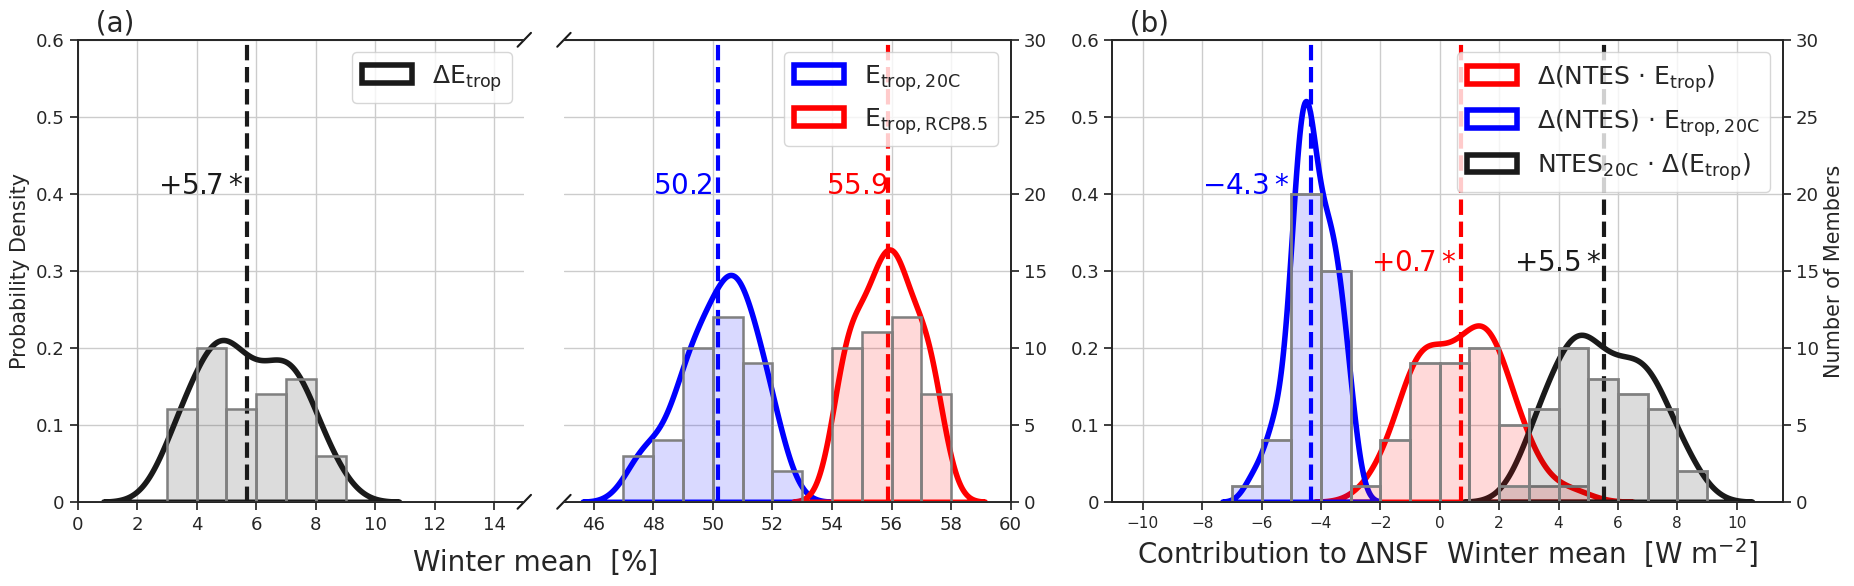

In [26]:
x = np.r_[0:14:.35, 46:60:.5]
y = np.sin(x)

fig = plt.figure( figsize=(22,6) )
gs = plt.GridSpec(1,4,
                       width_ratios=[.5,.5,.025,.75],
                       height_ratios=[1]
                       )


ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

sns.kdeplot(((E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean('time')*100)-
(E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')*100)),ax=ax,color='k',lw=4,shade=True,alpha=0
            ,label='$\Delta$E$_{\mathrm{trop}}$')
ax.axvline(((E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean('time')*100)-
(E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')*100)).mean(),ls='--',color='k',lw=3)
ax.text(2.7,.4,'$+{:.1f}*$'.format(((E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean('time')*100)-
(E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')*100)).mean().values),color='k',fontsize=20)

ax_2 = ax.twinx()
sns.histplot(((E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean('time')*100)-
(E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')*100)),ax=ax_2,
             alpha=.15,color='k',edgecolor='gray',lw=3,binrange=(0,15),bins=15)
ax_2.set_ybound(0,30)

sns.kdeplot(E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')*100,color='blue',ax=ax2,lw=4,shade=True,alpha=0
           ,label='E$_{\mathrm{trop,20C}}$')
sns.kdeplot(E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean('time')*100,color='red',ax=ax2,lw=4,shade=True,alpha=0
           ,label='E$_{\mathrm{trop,RCP8.5}}$')
ax2.axvline(E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean()*100,ls='--',color='blue',lw=3)
ax2.axvline(E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean()*100,ls='--',color='red',lw=3)
ax2.text(48,.4,'${:.1f}$'.format((E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean()*100).values),color='blue',fontsize=20)
ax2.text(53.8,.4,'${:.1f}$'.format((E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean()*100).values),color='red',fontsize=20)
ax2_2=ax2.twinx()
sns.histplot(E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')*100,color='blue',ax=ax2_2,
                         alpha=.15,edgecolor='gray',lw=3,binrange=(45,60),bins=15)
sns.histplot(E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean('time')*100,color='red',ax=ax2_2,
                         alpha=.15,edgecolor='gray',lw=3,binrange=(45,60),bins=15)
ax2_2.set_ybound(0,30)

ax3 = fig.add_subplot(gs[3])

sns.kdeplot(NTES_F.sel(time=winter_F).mean('time') 
             * E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean('time') -
            (NTES_H.sel(time=winter_H).mean('time')) 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')
             ,ax=ax3,color='red',lw=4,shade=True,alpha=0
            ,label='$\Delta$(NTES $\cdot$ E$_{\mathrm{trop}}$)')
sns.kdeplot(NTES_F.sel(time=winter_F).mean('time') 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time') -
            (NTES_H.sel(time=winter_H).mean('time')) 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')
             ,ax=ax3,color='blue',lw=4,shade=True,alpha=0
            ,label='$\Delta$(NTES) $\cdot$ E$_{\mathrm{trop,20C}}$')
sns.kdeplot(NTES_H.sel(time=winter_H).mean('time') 
             * E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean('time') -
            (NTES_H.sel(time=winter_H).mean('time')) 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')
             ,ax=ax3,color='k',lw=4,shade=True,alpha=0
            ,label='NTES$_{\mathrm{20C}}$ $\cdot$ $\Delta$(E$_{\mathrm{trop}}$)')
ax3.axvline((NTES_F.sel(time=winter_F).mean('time') 
             * E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean('time') -
            (NTES_H.sel(time=winter_H).mean('time')) 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')).mean(),ls='--',color='red',lw=3)
            
ax3.axvline((NTES_F.sel(time=winter_F).mean('time') 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time') -
            (NTES_H.sel(time=winter_H).mean('time')) 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')).mean(),ls='--',color='blue',lw=3)

ax3.axvline((NTES_H.sel(time=winter_H).mean('time') 
             * E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean('time') -
            (NTES_H.sel(time=winter_H).mean('time')) 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')).mean(),ls='--',color='k',lw=3)

ax3.text(-2.3,.3,'$+{:.1f}*$'.format((NTES_F.sel(time=winter_F).mean('time') 
             * E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean('time') -
            (NTES_H.sel(time=winter_H).mean('time')) 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')).mean().values),color='red',fontsize=20)
ax3.text(2.5,.3,'$+{:.1f}*$'.format((NTES_H.sel(time=winter_H).mean('time') 
             * E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean('time') -
            (NTES_H.sel(time=winter_H).mean('time')) 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')).mean().values),color='k',fontsize=20)
ax3.text(-8,.4,'${:.1f}*$'.format((NTES_F.sel(time=winter_F).mean('time') 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time') -
            (NTES_H.sel(time=winter_H).mean('time')) 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')).mean().values),color='blue',fontsize=20)

ax3.set_ylabel('')
ax3.set_xbound(-10,10)
ax3.set_xlabel('Contribution to $\Delta$NSF  Winter mean  [W m$^{\mathrm{-2}}$]',fontsize=20)

ax3_2 = ax3.twinx()
sns.histplot(NTES_F.sel(time=winter_F).mean('time') 
             * E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean('time') -
            (NTES_H.sel(time=winter_H).mean('time')) 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')
             ,ax=ax3_2,alpha=.15,edgecolor='gray',lw=3,binrange=(-10,10),bins=20,color='red')
sns.histplot(NTES_F.sel(time=winter_F).mean('time') 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time') -
            (NTES_H.sel(time=winter_H).mean('time')) 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')
             ,ax=ax3_2,alpha=.15,edgecolor='gray',lw=3,binrange=(-10,10),bins=20,color='blue')
sns.histplot(NTES_H.sel(time=winter_H).mean('time') 
             * E_tropF.where(np.logical_and(E_tropF>0,E_tropF<1)).mean('time') -
            (NTES_H.sel(time=winter_H).mean('time')) 
             * E_tropH.where(np.logical_and(E_tropH>0,E_tropH<1)).mean('time')
             ,ax=ax3_2,alpha=.15,edgecolor='gray',lw=3,binrange=(-10,10),bins=20,color='k')
ax3_2.set_ybound(0,30)

ax.set_xlim(0,15)
ax2.set_xlim(45,60)

ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax_2.spines['right'].set_visible(False)
ax2_2.spines['left'].set_visible(False)
ax2.tick_params(axis='y',which='major',length=0)
ax2.set_yticklabels([''])
ax2.set_ylabel('')
ax_2.set_ylabel('')
ax_2.set_yticklabels('')
ax_2.set_yticks([])
ax2_2.set_ylabel('')
ax.set_ylabel('Probability Density',fontsize=15)
ax3_2.set_ylabel('Number of Members',fontsize=15)

# Make the spacing between the two axes a bit smaller
plt.subplots_adjust(wspace=0.1)

d = .015 # how big to make the diagonal lines in axes coordinates
# arguments to pass plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal

kwargs.update(transform=ax2.transAxes) # switch to the bottom axes
ax2.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
ax2.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
ax.set_ybound(0,.6),ax2.set_ybound(0,.6),ax3.set_ybound(0,.6)
ax.grid(),ax2.grid(),ax3.grid()
label = ax.set_xlabel('Winter mean  [%]', fontsize = 20)
ax.xaxis.set_label_coords(1.025, -0.1)
ax.legend(fontsize=18),ax2.legend(fontsize=18),ax3.legend(fontsize=18,loc='upper right')
ax.set_yticklabels([0,.1,.2,.3,.4,.5,.6],fontsize=13);ax3.set_yticklabels([0,.1,.2,.3,.4,.5,.6],fontsize=13)
ax.set_xticklabels(np.arange(0,16,2),fontsize=13);ax2.set_xticklabels(np.arange(44,62,2),fontsize=13)
ax3.set_xticks(np.arange(-10,12,2))
ax2_2.set_yticklabels(np.arange(0,35,5),fontsize=13);ax3_2.set_yticklabels(np.arange(0,35,5),fontsize=13)
ax.set_title('  (a)',fontsize=20,loc='left');ax3.set_title('  (b)',fontsize=20,loc='left')
#plt.savefig('deltaEtrop.pdf', bbox_inches='tight')
;

<div class="alert alert-info">
    
<strong>Note:</strong> Surface energy flux changes can be converted to surface temperature changes (assuming a vertically uniform warming) by dividing the negative change in $\mathrm{W \space m^{-2}}$ by the local Arctic Planck feedback factor (approximately $−2.7\space\mathrm{W \space m^{-2} \space K^{-1}}$). The $0.7$ $\mathrm{W \space m^{-2}}$ energy gained by the surface indicates 0.3 K of surface warming; a result of 2 K of surface warming from increased winter-mean $E_{\textrm{trop}}$ partially compensated by decreased winter mean NTES.
    
</div>

### Figure S2

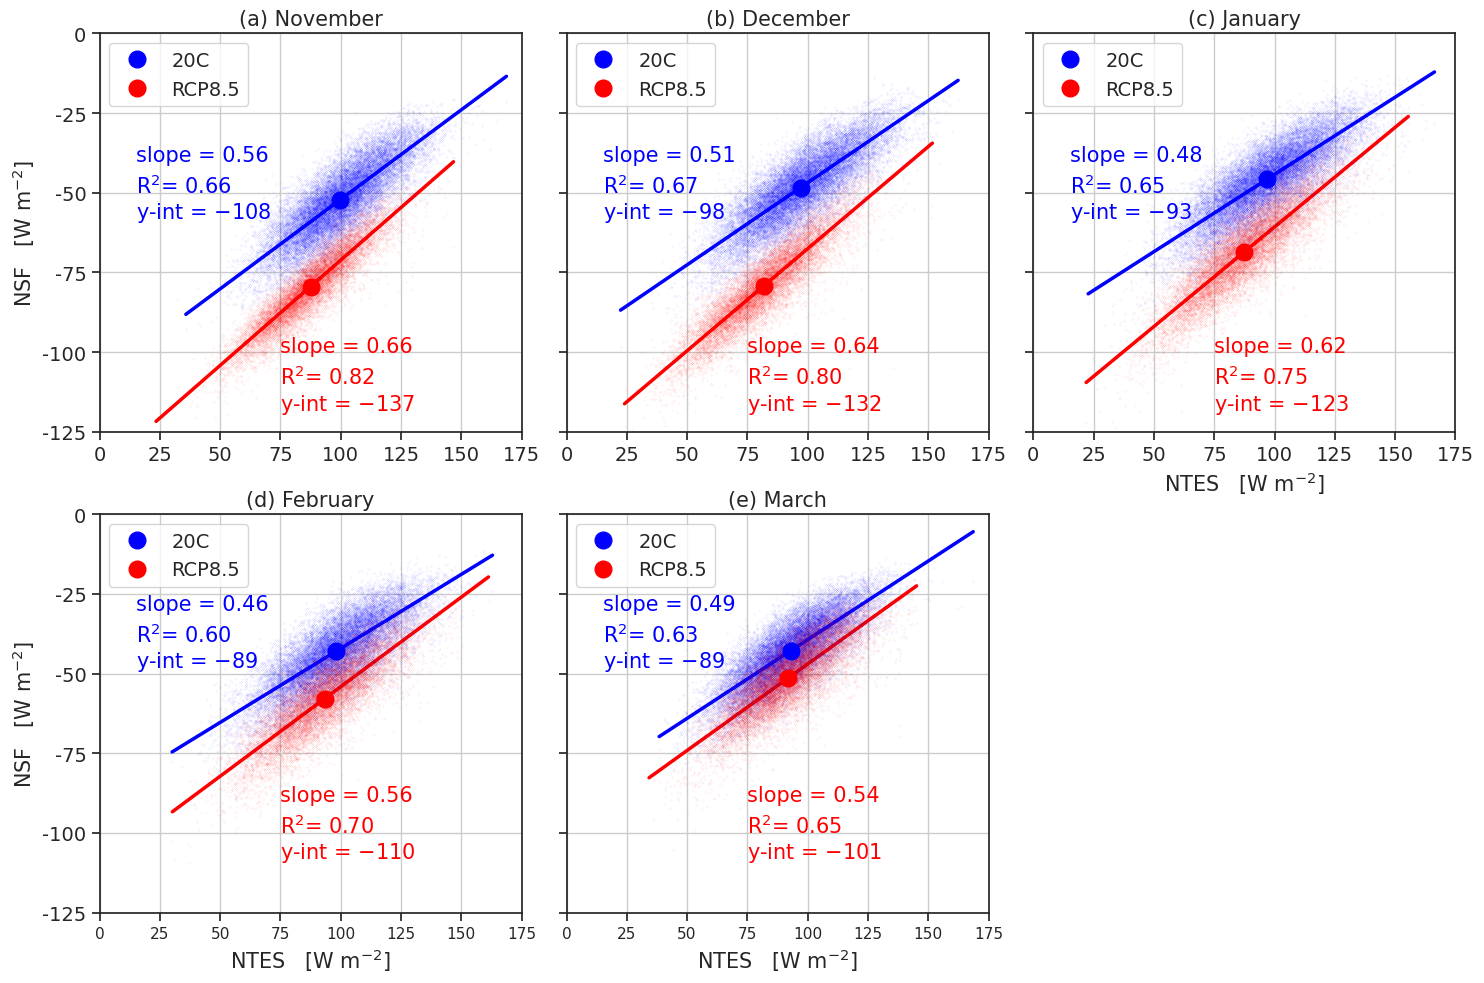

In [27]:
fig = plt.figure( figsize=(15,10) )
gs = plt.GridSpec(2, 3,
                       width_ratios=[1,1,1],
                       height_ratios=[1,1]
                       )

ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])
ax4 = fig.add_subplot(gs[3])
ax5 = fig.add_subplot(gs[4])

[sns.regplot(x=ufunc2(NTES_H.sel(time=winter_H).ffill('time'),comp.low_filt)
            .stack(all_points=['time','member_id']),
            y=NSF_H.sel(time=winter_H).where(NLR_H.time.dt.month==m)
            .stack(all_points=['time','member_id']),
           marker='o', color='blue', scatter=False,line_kws={'lw':2.5},ax=ax) 
 for m,ax in zip([11,12,1,2,3],[ax,ax2,ax3,ax4,ax5])] 

[sns.regplot(x=ufunc2(NTES_F.sel(time=winter_F).ffill('time'),comp.low_filt)
            .stack(all_points=['time','member_id']),
            y=NSF_F.sel(time=winter_F).where(NLR_F.time.dt.month==m)
            .stack(all_points=['time','member_id']),
           marker='o', color='red', scatter=False,line_kws={'lw':2.5},ax=ax)
 for m,ax in zip([11,12,1,2,3],[ax,ax2,ax3,ax4,ax5])] 

[ax.plot(ufunc2(NTES_H.sel(time=winter_H).ffill('time'),comp.low_filt)
            .stack(all_points=['time','member_id']),
            NSF_H.sel(time=winter_H).where(NLR_H.time.dt.month==m)
            .stack(all_points=['time','member_id']),
           marker='o', color='blue',rasterized=True,ls='',ms=.05,alpha=.75)
 for m,ax in zip([11,12,1,2,3],[ax,ax2,ax3,ax4,ax5])] 

[ax.plot(ufunc2(NTES_F.sel(time=winter_F).ffill('time'),comp.low_filt)
            .stack(all_points=['time','member_id']),
            NSF_F.sel(time=winter_F).where(NLR_F.time.dt.month==m)
            .stack(all_points=['time','member_id']),
           marker='o', color='red',rasterized=True,ls='',ms=.05,alpha=.75)
 for m,ax in zip([11,12,1,2,3],[ax,ax2,ax3,ax4,ax5])] 

[ax.plot(ufunc2(NTES_H.sel(time=winter_H).ffill('time'),comp.low_filt).where(NLR_H.time.dt.month==m).mean(),
           NSF_H.sel(time=winter_H).where(NLR_H.time.dt.month==m).mean(),c='blue',marker='o',ms=12,ls='',label='20C')
 for m,ax in zip([11,12,1,2,3],[ax,ax2,ax3,ax4,ax5])] 
    
[ax.plot(ufunc2(NTES_F.sel(time=winter_F).ffill('time'),comp.low_filt).where(NLR_F.time.dt.month==m).mean(),
           NSF_F.sel(time=winter_F).where(NLR_F.time.dt.month==m).mean(),c='red',marker='o',ms=12,ls='',label='RCP8.5')
 for m,ax in zip([11,12,1,2,3],[ax,ax2,ax3,ax4,ax5])] 

ax.set_xbound(0,175),ax2.set_xbound(0,175),ax3.set_xbound(0,175),ax4.set_xbound(0,175),ax5.set_xbound(0,175)
ax.set_ybound(-125,0),ax2.set_ybound(-125,0),ax3.set_ybound(-125,0),ax4.set_ybound(-125,0),ax5.set_ybound(-125,0)
ax.set_xticks(np.arange(0,200,25)),ax2.set_xticks(np.arange(0,200,25)),ax3.set_xticks(np.arange(0,200,25)),ax4.set_xticks(np.arange(0,200,25)),ax5.set_xticks(np.arange(0,200,25))
ax.set_yticks(np.arange(-125,25,25)),ax2.set_yticks(np.arange(-125,25,25)),ax3.set_yticks(np.arange(-125,25,25)),ax4.set_yticks(np.arange(-125,25,25)),ax5.set_yticks(np.arange(-125,25,25))
ax2.set_yticklabels(''),ax3.set_yticklabels(''),ax5.set_yticklabels('')
ax.set_yticklabels(np.arange(-125,25,25),fontsize=14),ax4.set_yticklabels(np.arange(-125,25,25),fontsize=14)
ax.set_xticklabels(np.arange(0,200,25),fontsize=14),ax2.set_xticklabels(np.arange(0,200,25),fontsize=14),ax3.set_xticklabels(np.arange(0,200,25),fontsize=14)
ax2.set_ylabel(None),ax3.set_ylabel(None),ax5.set_ylabel(None)
ax.set_xlabel(None),ax2.set_xlabel(None)
ax.grid(),ax2.grid(),ax3.grid(),ax4.grid(),ax5.grid()

slopeH = np.array([sp.linregress(ufunc2(NTES_H.sel(time=winter_H).ffill('time')
                     ,comp.low_filt).where(NLR_H.time.dt.month==m).stack(all_points=['time','member_id']).dropna('all_points'),
NSF_H.sel(time=winter_H).ffill('time').where(NLR_H.time.dt.month==m).stack(all_points=['time','member_id']
                                                                   ).dropna('all_points')).slope
    for m in NLR_H.sel(time=winter_H).groupby('time.month').mean().month])

interceptH = np.abs(np.array([sp.linregress(ufunc2(NTES_H.sel(time=winter_H).ffill('time')
                     ,comp.low_filt).where(NLR_H.time.dt.month==m).stack(all_points=['time','member_id']).dropna('all_points'),
NSF_H.sel(time=winter_H).ffill('time').where(NLR_H.time.dt.month==m).stack(all_points=['time','member_id']
                                                                   ).dropna('all_points')).intercept
    for m in NLR_H.sel(time=winter_H).groupby('time.month').mean().month]))

rsquaredH = np.array([sp.linregress(ufunc2(NTES_H.sel(time=winter_H).ffill('time')
                     ,comp.low_filt).where(NLR_H.time.dt.month==m).stack(all_points=['time','member_id']).dropna('all_points'),
NSF_H.sel(time=winter_H).ffill('time').where(NLR_H.time.dt.month==m).stack(all_points=['time','member_id']
                                                                   ).dropna('all_points')).rvalue**2
    for m in NLR_H.sel(time=winter_H).groupby('time.month').mean().month])

slopeF = np.array([sp.linregress(ufunc2(NTES_F.sel(time=winter_F).ffill('time')
                     ,comp.low_filt).where(NLR_F.time.dt.month==m).stack(all_points=['time','member_id']).dropna('all_points'),
NSF_F.sel(time=winter_F).ffill('time').where(NLR_F.time.dt.month==m).stack(all_points=['time','member_id']
                                                                   ).dropna('all_points')).slope
    for m in NLR_F.sel(time=winter_F).groupby('time.month').mean().month])

interceptF = np.abs(np.array([sp.linregress(ufunc2(NTES_F.sel(time=winter_F).ffill('time')
                     ,comp.low_filt).where(NLR_F.time.dt.month==m).stack(all_points=['time','member_id']).dropna('all_points'),
NSF_F.sel(time=winter_F).ffill('time').where(NLR_F.time.dt.month==m).stack(all_points=['time','member_id']
                                                                   ).dropna('all_points')).intercept
    for m in NLR_F.sel(time=winter_F).groupby('time.month').mean().month]))

rsquaredF = np.array([sp.linregress(ufunc2(NTES_F.sel(time=winter_F).ffill('time')
                     ,comp.low_filt).where(NLR_F.time.dt.month==m).stack(all_points=['time','member_id']).dropna('all_points'),
NSF_F.sel(time=winter_F).ffill('time').where(NLR_F.time.dt.month==m).stack(all_points=['time','member_id']
                                                                   ).dropna('all_points')).rvalue**2
    for m in NLR_F.sel(time=winter_F).groupby('time.month').mean().month])


ax.text(15,-40,'slope = {:.2f}'.format(slopeH[3]),c='blue',fontsize=15)
ax.text(75,-100,'slope = {:.2f}'.format(slopeF[3]),c='red',fontsize=15)

ax2.text(15,-40,'slope = {:.2f}'.format(slopeH[4]),c='blue',fontsize=15)
ax2.text(75,-100,'slope = {:.2f}'.format(slopeF[4]),c='red',fontsize=15)

ax3.text(15,-40,'slope = {:.2f}'.format(slopeH[0]),c='blue',fontsize=15)
ax3.text(75,-100,'slope = {:.2f}'.format(slopeF[0]),c='red',fontsize=15)

ax4.text(15,-30,'slope = {:.2f}'.format(slopeH[1]),c='blue',fontsize=15)
ax4.text(75,-90,'slope = {:.2f}'.format(slopeF[1]),c='red',fontsize=15)

ax5.text(15,-30,'slope = {:.2f}'.format(slopeH[2]),c='blue',fontsize=15)
ax5.text(75,-90,'slope = {:.2f}'.format(slopeF[2]),c='red',fontsize=15)

ax.text(15,-50,'R$^{2}$'+'= {:.2f}'.format(rsquaredH[3]),c='blue',fontsize=15)
ax.text(75,-110,'R$^{2}$'+'= {:.2f}'.format(rsquaredF[3]),c='red',fontsize=15)

ax2.text(15,-50,'R$^{2}$'+'= {:.2f}'.format(rsquaredH[4]),c='blue',fontsize=15)
ax2.text(75,-110,'R$^{2}$'+'= {:.2f}'.format(rsquaredF[4]),c='red',fontsize=15)

ax3.text(15,-50,'R$^{2}$'+'= {:.2f}'.format(rsquaredH[0]),c='blue',fontsize=15)
ax3.text(75,-110,'R$^{2}$'+'= {:.2f}'.format(rsquaredF[0]),c='red',fontsize=15)

ax4.text(15,-40,'R$^{2}$'+'= {:.2f}'.format(rsquaredH[1]),c='blue',fontsize=15)
ax4.text(75,-100,'R$^{2}$'+'= {:.2f}'.format(rsquaredF[1]),c='red',fontsize=15)

ax5.text(15,-40,'R$^{2}$'+'= {:.2f}'.format(rsquaredH[2]),c='blue',fontsize=15)
ax5.text(75,-100,'R$^{2}$'+'= {:.2f}'.format(rsquaredF[2]),c='red',fontsize=15)

ax.text(15,-58,'y-int = $-${:.0f}'.format(interceptH[3]),c='blue',fontsize=15)
ax.text(75,-118,'y-int = $-${:.0f}'.format(interceptF[3]),c='red',fontsize=15)

ax2.text(15,-58,'y-int = $-${:.0f}'.format(interceptH[4]),c='blue',fontsize=15)
ax2.text(75,-118,'y-int = $-${:.0f}'.format(interceptF[4]),c='red',fontsize=15)

ax3.text(15,-58,'y-int = $-${:.0f}'.format(interceptH[0]),c='blue',fontsize=15)
ax3.text(75,-118,'y-int = $-${:.0f}'.format(interceptF[0]),c='red',fontsize=15)

ax4.text(15,-48,'y-int = $-${:.0f}'.format(interceptH[1]),c='blue',fontsize=15)
ax4.text(75,-108,'y-int = $-${:.0f}'.format(interceptF[1]),c='red',fontsize=15)

ax5.text(15,-48,'y-int = $-${:.0f}'.format(interceptH[2]),c='blue',fontsize=15)
ax5.text(75,-108,'y-int = $-${:.0f}'.format(interceptF[2]),c='red',fontsize=15)

ax.legend(fontsize=14,loc='upper left'),ax2.legend(fontsize=14,loc='upper left'),ax3.legend(fontsize=14,loc='upper left')
ax4.legend(fontsize=14,loc='upper left'),ax5.legend(fontsize=14,loc='upper left')

ax.set_title('(a) November',fontsize=15),ax2.set_title('(b) December',fontsize=15),ax3.set_title('(c) January',fontsize=15)
ax4.set_title('(d) February',fontsize=15),ax5.set_title('(e) March',fontsize=15)

ax.set_ylabel('NSF   [W m$^{-2}$]',fontsize=15),ax4.set_ylabel('NSF   [W m$^{-2}$]',fontsize=15)
ax3.set_xlabel('NTES   [W m$^{-2}$]',fontsize=15),ax4.set_xlabel('NTES   [W m$^{-2}$]',fontsize=15),ax5.set_xlabel('NTES   [W m$^{-2}$]',fontsize=15)

fig.tight_layout()
#plt.savefig('linreg.pdf', bbox_inches='tight')